# Exploring and visualizing clustering

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

rs = np.random.RandomState()
rs.seed(42)

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/'


In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# Bin clustering
indir = '../output/figures/5.2_Preimplantation.simplified_bin_clustering.part1.Performing_clustering.allelic_bias_correction/'
BIN_CLUSTER_FN = indir + 'FR231103.clustering_of_bins.binsize_100000.tsv'

# Gene information
GENESFN = HOME + 'references/mouse/mm10/genomic_element_info/FR200630.BioMart.mm10.all_genes.top_transcripts.txt.gz'
PARKFN = HOME + 'projects/preimplantation/DRA001066/data/tables/FR200923.Park_clusters_by_Ensembl_ID.tsv'

# Repeat information


# 0. Loading bin clustering

In [5]:
bin_clusters = pd.read_table(BIN_CLUSTER_FN)
bin_clusters['chrom'] = bin_clusters['chrom'].astype(str)
bin_clusters.groupby('Kcluster').size()

Kcluster
1    4623
2    3910
3    3990
4    2141
5    2490
6    4558
dtype: int64

In [6]:
to_save = bin_clusters.copy().drop(columns='bin_ind')
tmp = {1: 'cLADs', 2: 'ET-iLADs', 3: 'ET-LADs', 4: 'PT-LADs', 5: 'cH3K27me3', 6: 'ciLADs'}
to_save['cluster_name'] = to_save['Kcluster'].apply(func = lambda n: tmp[n])

outfn = '/Users/f.rang/Downloads/Extended_Data_Table_6.genomic_clusters.mm10.tsv.gz'
to_save.to_csv(outfn, sep='\t', header=True, index=False)

# 1. Loading Kind data

In [70]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [8]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
treatment_order = [
    'no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b', 'alpha-amanitin'
]

In [9]:
anno = pd.read_csv(ANNOFN, sep='\t')
print(anno.fusion_construct.unique())
anno = anno[anno['fusion_construct'].isin(['Dam-only', 'Dam-Lmnb1', 'Dam-aH3K27me3', 'Dam-Cbx1(CD)', 'Cbx1(FL)-Dam'])]
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.treatment.isin(treatment_order)]
# anno = anno[~((anno.fusion_construct != 'Dam-Lmnb1') & anno.treatment.isin(['EED_mKO', 'EED_ctrl']))]
anno = anno.set_index('damid_name')
anno = anno[anno.DamID_PASS].reset_index(drop=True)

['Dam-Lmnb1' 'Dam-only' 'Dam-aH3K27me3' 'Dam-aH3K27me3(mut)'
 'Dam-Cbx1(CD)' 'Cbx1(FL)-Dam']


In [10]:
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
assert all(anno['treatment'].isin(treatment_order))
anno['treatment'] = pd.Categorical(anno['treatment'], categories=treatment_order)

In [11]:
tmp = anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']).size()
tmp[tmp>0]

fusion_construct  stage   genotype                treatment     
Cbx1(FL)-Dam      2cell   homozygous              no_treatment       27
Dam-Cbx1(CD)      2cell   C57BL/6J_x_JF1/Ms       EED_ctrl            6
                                                  EED_mKO            11
                          homozygous              no_treatment       37
Dam-Lmnb1         zygote  CBAB6F1_x_CAST/EiJ      no_treatment       14
                          homozygous              no_treatment      107
                  2cell   C57BL/6J_x_JF1/Ms       EED_ctrl           87
                                                  EED_mKO            54
                          CBAB6F1_x_CAST/EiJ      no_treatment       27
                                                  Lap2b              11
                                                  Cbx7(CD)-Lap2b     39
                          homozygous              no_treatment      218
                                                  Lap2b              31

## 1.2 Loading mappability

In [12]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [13]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [14]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__Contact Frequency__

In [15]:
contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
    
    if info[0] not in ['Dam-only', 'Dam-Lmnb1']:
        print('Loading Dam-normalized CF values for: ', info)
        fn = fn.replace('contact_frequency', 'contact_frequency_damnorm')
    
    name = (info[0], info[1], info[2], info[3])
    
    if len(glob(fn)) == 0:
        print('CF does not exist for', info)
        continue
        
    contact_freq['combined'][name] =  load_count_file(fn)
    
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
            if info[0] not in ['Dam-only', 'Dam-Lmnb1']:
                fn = fn.replace('contact_frequency', 'contact_frequency_damnorm')
            contact_freq[parent][name] =  load_count_file(fn)

Loading Dam-normalized CF values for:  ('Cbx1(FL)-Dam', '2cell', 'homozygous', 'no_treatment', False)
Loading Dam-normalized CF values for:  ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True)
CF does not exist for ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True)
Loading Dam-normalized CF values for:  ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True)
CF does not exist for ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True)
Loading Dam-normalized CF values for:  ('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment', False)
Loading Dam-normalized CF values for:  ('Dam-aH3K27me3', '2cell', 'homozygous', 'no_treatment', False)
Loading Dam-normalized CF values for:  ('Dam-aH3K27me3', '2cell', 'homozygous', 'Lap2b', False)
Loading Dam-normalized CF values for:  ('Dam-aH3K27me3', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b', False)


__in silico populations__

In [16]:
damid_insilico = {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = INSILICO.format(
        construct = info[0], stage = info[1], treatment = info[3], 
        sample = '*', genotype = gt_name, binsize=BINSIZE
    )
    fns = glob(fn)
    print(info, len(fns))
    name = (info[0], info[1], info[2], info[3])
    
    for fn in fns:
        counts = load_count_file(fn)
        counts = {c: counts[c].astype(int) for c in chrom_order}
        
        if name in damid_insilico['combined']:
            damid_insilico['combined'][name] = {c: damid_insilico['combined'][name][c] + counts[c] for c in chrom_order}
        else:
            damid_insilico['combined'][name] = counts

    # load parental
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = INSILICO.format(
                construct = info[0], stage = info[1], treatment = info[3], 
                sample = '1cell', genotype = gt_name, binsize=BINSIZE
            )
            fns = glob(fn)
            
            for fn in fns:
                counts =  load_count_file(fn)
                counts = {c: counts[c].astype(int) for c in chrom_order}

                if name in damid_insilico[parent]:
                    damid_insilico[parent][name] = {c: damid_insilico[parent][name][c] + counts[c] for c in chrom_order}
                else:
                    damid_insilico[parent][name] = counts
                

('Cbx1(FL)-Dam', '2cell', 'homozygous', 'no_treatment', False) 1
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True) 1
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True) 1
('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', 'zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 2
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment', False) 2
('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b', False) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b', False) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'alpha-amanitin', False) 1
('Dam-Lmnb1', '8cell', 'CBAB6F

__RPKM normalization of _in silico_ populations__

In [17]:
damid_insilico_rpkm = {p: dict() for p in ['maternal', 'paternal', 'combined']}

# Normalize DamID data
for sample, _ in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']):
    gt = sample[1]
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print(sample)
            continue


        if parent in ['maternal', 'paternal']:
            dm = sum([damid_insilico['maternal'][sample][c].sum() for c in chrom_order])
            dp = sum([damid_insilico['paternal'][sample][c].sum() for c in chrom_order])
            d = dm + dp

            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE, depth=d)

        else:
            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE)

('Cbx1(FL)-Dam', '2cell', 'homozygous', 'no_treatment')
('Cbx1(FL)-Dam', '2cell', 'homozygous', 'no_treatment')
('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment')
('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment')
('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment')
('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment')
('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment')
('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment')
('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
('Dam-Lmnb1', '2cell', 'homozygous', 'alpha-amanitin')
('Dam-Lmnb1', '2cell', 'homozygous', 'alpha-amanitin')
('Dam-Lmnb1', '8cell', 'homozygous', 'no_treatment')
('Dam-Lmnb1', '8cell', 'homozygous', 'no_treatment')
('Dam-aH3K27me3', '2cell', 'homozygous', 'no_treatment')
('Dam-aH3K27me3', '2cell', 'homozygous', 'no_treatment')
('Dam-aH3K27me3', '2cell', 'ho

__log2OE normalization of _in silico_ populations__

In [18]:
# RPKM normalize mappability data
mapab_rpkm = dict()
for gt in mapab_gt:
    mapab_rpkm[gt] = dict()
    
    for p in mapab_gt[gt]:
        m = mapab_gt[gt][p]
        
        if p in ['maternal', 'paternal']:
            dm = sum([mapab_gt[gt]['maternal'][c].sum() for c in chrom_order])
            dp = sum([mapab_gt[gt]['paternal'][c].sum() for c in chrom_order])
            d = dm+dp
            m = rpkm_normalize(m, binsize=BINSIZE, depth=d)
        else:
            m = rpkm_normalize(m, binsize=BINSIZE)
            
        mapab_rpkm[gt][p] = m
        

# Normalize DamID data
damid_insilico_logoe = {p: dict() for p in ['maternal', 'paternal', 'combined']}
for sample, _ in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']):
    gt = sample[2]
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
#             print(sample, parent)
            continue
            
        rpkm = damid_insilico_rpkm[parent][sample]
        
        if sample[0] not in ['Dam-only', 'Dam-Lmnb1']:
            print(sample)
            ctrl = ('Dam-only', sample[1], sample[2], sample[3])
            if ctrl not in damid_insilico_rpkm[parent]:
                if parent != 'combined':
                    continue
                print('--------------------------------------')
                print('No appropraite Dam-only control available for:', sample)
                print('Using 2-cell WT Dam-only instead')
                print('--------------------------------------')
                ctrl = ('Dam-only', '2cell', 'homozygous', 'no_treatment')
                if ctrl not in damid_insilico_rpkm[parent]:
                    continue
            logoe = {c: np.log2( (rpkm[c] + .1) / (damid_insilico_rpkm[parent][ctrl][c] + .1) ) for c in chrom_order}
        else:
            logoe = {c: np.log2( (rpkm[c] + .1) / (mapab_rpkm[gt][parent][c] + .1) ) for c in chrom_order}
        
        damid_insilico_logoe[parent][sample] = logoe


('Cbx1(FL)-Dam', '2cell', 'homozygous', 'no_treatment')
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
--------------------------------------
No appropraite Dam-only control available for: ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
Using 2-cell WT Dam-only instead
--------------------------------------
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
--------------------------------------
No appropraite Dam-only control available for: ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
Using 2-cell WT Dam-only instead
--------------------------------------
('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment')
('Dam-aH3K27me3', '2cell', 'homozygous', 'no_treatment')
('Dam-aH3K27me3', '2cell', 'homozygous', 'Lap2b

## 1.4 Loading allele visibility

In [19]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 2. Loading external data sets

In [20]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
ext_anno = pd.read_table(FN)
ext_anno = ext_anno[ext_anno.treatment.isin(['no', 'alpha_amanitin'])]
ext_anno = ext_anno[~ext_anno.target.isin(['H3'])]

# select samples where duplicate stages etc are available
sample_selection = {
    'H3K4me3': ext_anno.dataset_id.isin(['GSE71434', 'GSE73952']) & (~ext_anno.sample_id.isin(['GSE71434_016', 'GSE71434_019', 'GSE73952_028'])),
    'H3K27me3': ext_anno.dataset_id.isin(['GSE73952', 'GSE76687']) & (~ext_anno.sample_id.isin(['GSE76687_019'])),
    'H3K9me3': ext_anno.dataset_id.isin(['GSE97778', 'Encode_Hardison']) & (~ext_anno.sample_id.isin(['GSE76687_019', 'GSE97778_016'])),
    'accessibility': ext_anno.dataset_id.isin(['GSE66390']) & (~ext_anno.sample_id.isin(['GSE66390_007']))
}

select_ind = (ext_anno.dataset_id == ext_anno.dataset_id)
for target, ind in sample_selection.items():
    new_ind = (ext_anno.target != target) | ind
    select_ind = select_ind & new_ind
ext_anno = ext_anno[select_ind]

# select stages of interest
select_stages = [
    'sperm', 
    'growing_oocyte_7d', 'growing_oocyte_10d', 'growing_oocyte_14d', 'FG_oocyte', 'GV_oocyte', 'MII_oocyte', 
    'zygote', 'PN3_zygote', 'PN5_zygote', 
    '2cell_early', '2cell', '2cell_late',
    '4cell', '8cell', 'morula', 'blastocyst', 'ICM', 'mESC'
]

ext_anno = ext_anno[ext_anno.stage.isin(select_stages)]
ext_anno['stage'] = pd.Categorical(ext_anno['stage'], select_stages)

# only keep input control samples whose partner is still in sample sheet
valid_controls = ext_anno.control_id.unique()
ind_ctrl = (ext_anno.target == 'input') & ext_anno.sample_id.isin(valid_controls)
ind_rest = ext_anno.target != 'input'
ext_anno = ext_anno[ind_ctrl | ind_rest]

FNFMT = {
    'combined': '../../combining_all_external_data/data/binned/FR230828.external_data.RPKM.binsize_%d.tsv.gz',
    'maternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_maternal.RPKM.binsize_%d.tsv.gz',
    'paternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_paternal.RPKM.binsize_%d.tsv.gz',
    'allele_vis': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.allele_vis.fraction.binsize_%d.tsv.gz'
}

In [21]:
ext_anno[ext_anno.dataset_id == 'Encode_Hardison']

sample_id technique stage   target treatment  is_heterozygous  \
125  EncodeHardison_001  ChIP-seq  mESC  H3K9me3        no            False   
128  EncodeHardison_004  ChIP-seq  mESC    input        no            False   

      genotype genotype_maternal genotype_paternal       dataset_id  \
125  E14TG2a.4               NaN               NaN  Encode_Hardison   
128  E14TG2a.4               NaN               NaN  Encode_Hardison   

             control_id replicate library_layout read_length_bp  
125  EncodeHardison_004      rep1         SINGLE             45  
128                none      rep1         SINGLE             45

In [22]:
# tmp = ext_anno.groupby(['dataset_id', 'technique', 'target', 'stage', 'is_heterozygous', 'genotype']).size()
# tmp = tmp[tmp>0].reset_index()
# tmp.to_csv('/Users/f.rang/Desktop/tmp.tsv', sep='\t', header=True, index=False)
# tmp

In [23]:
ext_data = {p: dict() for p in ['combined', 'maternal', 'paternal', 'allele_vis']}

for dat, fnfmt in FNFMT.items():
    fn = fnfmt % BINSIZE
    df = pd.read_table(fn, dtype={'chrom': str})
    
    for sample in ext_anno.sample_id.values:
        if sample not in df.columns:
            continue
            
        bed = df[['chrom', 'start', 'end', sample]].copy().rename(columns={sample: 'reads'})
        D = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data[dat][sample] = {c: D[c][:len(mapab[c])] for c in chrom_order}
        
    if dat == 'combined':
        bed = df[['chrom', 'start', 'end', 'blacklisted']].copy().rename(columns={'blacklisted': 'reads'})
        D = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data['blacklisted'] = {c: D[c][:len(mapab[c])] for c in chrom_order}

In [24]:
for target, df in ext_anno.groupby('target'):
    print(target)
    print(df.stage.sort_values().unique().astype(str))
    print('-----------')

5fCpG
['2cell_early']
-----------
5mCpG
['sperm' 'MII_oocyte' '2cell_early' '4cell' 'ICM']
-----------
5mhCpG
['2cell_early']
-----------
H2AK119ub1
['growing_oocyte_7d' 'FG_oocyte' 'MII_oocyte' 'PN5_zygote' '2cell_early'
 '2cell_late' 'morula' 'blastocyst' 'mESC']
-----------
H3K27ac
['GV_oocyte' 'MII_oocyte' 'zygote' '2cell_early' '2cell_late' 'morula'
 'mESC']
-----------
H3K27me3
['sperm' 'growing_oocyte_7d' 'growing_oocyte_14d' 'GV_oocyte' 'MII_oocyte'
 'PN5_zygote' '2cell_early' '2cell' '2cell_late' '4cell' '8cell' 'morula'
 'ICM' 'mESC']
-----------
H3K4me3
['sperm' 'growing_oocyte_7d' 'growing_oocyte_10d' 'growing_oocyte_14d'
 'GV_oocyte' 'MII_oocyte' 'PN5_zygote' '2cell_early' '2cell' '2cell_late'
 '4cell' '8cell' 'morula' 'ICM' 'mESC']
-----------
H3K9ac
['zygote' '2cell_early' '2cell_late' 'morula' 'mESC']
-----------
H3K9me3
['sperm' 'MII_oocyte' 'PN3_zygote' '2cell_early' '2cell' '2cell_late'
 '4cell' '8cell' 'morula' 'ICM' 'mESC']
-----------
accessibility
['2cell_early' 

# 3. Generating shared sample sheet for external and internal data

In [25]:
color_dict['target']['Cbx1'] = color_dict['target']['H3K9me3']

In [26]:
# Format DamID metadata
df0 = anno.groupby(['fusion_construct', 'construct', 'stage', 'treatment', 'genotype', 'is_heterozygous']).size()
df0 = df0[df0>0]
df0 = df0.reset_index().drop(columns=[0])
df0['technique'] = 'DamID'
tmp = {'untethered': 'accessibility', 'Lmnb1': 'Lmnb1', 'aH3K27me3': 'H3K27me3', 'Cbx1(CD)': 'H3K9me3', 'Cbx1(FL)': 'Cbx1'}
df0['target'] = df0['construct'].apply(func = lambda c: tmp[c])
df0['sample_id'] = df0.apply(axis=1, func = lambda r: (r['fusion_construct'], r['stage'], r['genotype'], r['treatment']))
df0['control_id'] = 'none'
df0['dataset_id'] = 'Kind'
df0.loc[(df0.genotype == 'C57BL/6J_x_JF1/Ms')&(df0.target=='H3K9me3'), 'is_heterozygous'] = False
df0 = df0.drop(columns=['fusion_construct', 'construct'])

# Format external metadata
df1 = ext_anno.copy()
cols = [
    'stage', 'treatment', 'genotype', 'is_heterozygous', 
    'technique', 'target', 'sample_id', 'control_id', 'dataset_id'
]
df1 = df1[cols]
df1.loc[df1.treatment == 'no', 'treatment'] = 'no_treatment'

# combine
comb_anno = pd.concat([df0, df1], axis=0).reset_index(drop=True)
comb_anno.loc[comb_anno.treatment=='alpha_amanitin','treatment'] = 'alpha-amanitin'

# set treatment as categorical
assert all(comb_anno['treatment'].isin(treatment_order))
comb_anno['treatment'] = pd.Categorical(comb_anno['treatment'], categories=treatment_order)

# set stages as categorical
tmp = [
    'sperm', 
    'growing_oocyte_7d', 'growing_oocyte_10d', 'growing_oocyte_14d', 'FG_oocyte', 'GV_oocyte', 'MII_oocyte', 
    'PN3_zygote', 'zygote', 'PN5_zygote', 
    '2cell_early', '2cell', '2cell_late',
    '4cell', '8cell', 'morula', 'blastocyst', 'ICM', 'mESC'
]
ind = comb_anno['stage'].isin(tmp)
assert all(ind), comb_anno.loc[~ind,'stage'].unique()
comb_anno['stage'] = pd.Categorical(comb_anno['stage'], categories=tmp)

# final details
comb_anno = comb_anno.sort_values(by=['technique', 'target', 'stage', 'treatment', 'genotype'])
comb_anno['has_control'] = comb_anno['control_id'] != 'none'
comb_anno.head()

stage       treatment           genotype  is_heterozygous technique  \
25  2cell_early    no_treatment  C57BL/6N_x_DBA/2N             True  ATAC-seq   
26  2cell_early  alpha-amanitin  C57BL/6N_x_DBA/2N             True  ATAC-seq   
27   2cell_late    no_treatment  C57BL/6N_x_DBA/2N             True  ATAC-seq   
28        4cell    no_treatment  C57BL/6N_x_DBA/2N             True  ATAC-seq   
29        8cell    no_treatment  C57BL/6N_x_DBA/2N             True  ATAC-seq   

           target     sample_id control_id dataset_id  has_control  
25  accessibility  GSE66390_001       none   GSE66390        False  
26  accessibility  GSE66390_002       none   GSE66390        False  
27  accessibility  GSE66390_003       none   GSE66390        False  
28  accessibility  GSE66390_004       none   GSE66390        False  
29  accessibility  GSE66390_005       none   GSE66390        False

# 4. Loading genomic regions of interest

## 4.1 Repeats

In [27]:
REPEATFN = '/Users/f.rang/surfdrive/Kind/data/references/mouse/mm10/repeat_masker/mm10.RepeatMasker.txt.gz'

In [28]:
repeats = pd.read_table(REPEATFN)

In [29]:
# filter out repeat classes that are not of interest
ind = repeats.repClass.isin(['Low_complexity', 'Other', 'Unknown', 'Simple_repeat']) | repeats.repClass.str.contains('\?')
repeats = repeats[~ind]

In [30]:
# format dataframe
repeats = repeats.rename(columns={'genoName': 'chrom', 'genoStart': 'start', 'genoEnd': 'end'})
repeats['chrom'] = repeats['chrom'].apply(func = lambda c: c.strip('chr'))

# filter out repFamilies that are uncertain
ind = repeats.repFamily.str.contains('\?')
repeats = repeats[~ind]

# filter out invalid chromosomes
repeats = repeats[repeats.chrom.isin(chrom_order)]

In [31]:
repeats.groupby(['repClass', 'repFamily']).size()

repClass   repFamily    
DNA        DNA                1001
           MULE-MuDR           583
           MuDR                153
           PiggyBac            209
           TcMar                52
           TcMar-Mariner      1079
           TcMar-Pogo           21
           TcMar-Tc2          1786
           TcMar-Tigger      35100
           hAT                1945
           hAT-Blackjack      4564
           hAT-Charlie      105631
           hAT-Tip100         9323
LINE       CR1               14144
           Dong-R4             138
           L1               903043
           L2                67828
           RTE-BovB            253
           RTE-X              1703
LTR        ERV1              71649
           ERVK             318474
           ERVL             117818
           ERVL-MaLR        454137
           Gypsy              1857
           LTR                 818
RC         Helitron            345
RNA        RNA                 691
SINE       Alu              57

### Generating density tracks per repClass and repFamily

In [32]:
repeat_density = dict()

g_rep = repeats.groupby(['repClass', 'repFamily', 'repName'])
N = len(list(g_rep))

for (repclass, repfam, repname), df_class in tqdm(g_rep, total=N):
    density = dict()
    
    for chrom in chrom_order:
        df = df_class[df_class.chrom==chrom].copy()
        df['bin_start'] = df['start'] // BINSIZE
        df['bin_end'] = df['end'] // BINSIZE
        
        # initiate empty array
        D = np.zeros(len(mapab[chrom]))
        
        # deal with repeats that fall in exactly 1 bin
        ind = df.bin_start == df.bin_end
        bin_indices = df.loc[ind,'bin_start'].values
        np.add.at(D, bin_indices, 1)
        
        # deal with repeats that span multiple bins
        for _, row in df[~ind].iterrows():
            s = row['start']//BINSIZE
            e = int(np.ceil(row['end'] / BINSIZE))
            D[s:e] += 1
            
        density[chrom] = D.astype(int)
        
    repeat_density[(repclass, repfam, repname)] = density
    
    if (repclass) in repeat_density:
        repeat_density[(repclass)] = {c: repeat_density[(repclass)][c] + density[c] for c in density}
    else:
        repeat_density[(repclass)] = density
        
    if (repclass, repfam) in repeat_density:
        repeat_density[(repclass, repfam)] = {c: repeat_density[(repclass, repfam)][c] + density[c] for c in density}
    else:
        repeat_density[(repclass, repfam)] = density

  0%|          | 0/1151 [00:00<?, ?it/s]

## 4.2 Genes

### 4.2.1 All genes

In [33]:
genes = pd.read_csv(GENESFN, sep='\t')
genes = genes.rename(columns={
    'Chromosome/scaffold name': 'chrom',
    'Gene start (bp)': 'gene_start',
    'Gene end (bp)': 'gene_end',
    'Strand': 'strand',
    'Transcript start (bp)': 'transcript_start',
    'Transcript end (bp)': 'transcript_end',
    'Transcription start site (TSS)': 'tss',
    'Gene stable ID version': 'gid',
    'Transcript stable ID version': 'tid',
    'Gene name': 'gene_name',
    'Gene type': 'gene_type',
    'Transcript length (including UTRs and CDS)': 'transcript_length'
})
genes = genes.drop(columns=['Transcript support level (TSL)', 'GENCODE basic annotation', 'APPRIS annotation'])

genes['gid'] = genes.gid.apply(func = lambda gid: gid.split('.')[0])
genes['tid'] = genes.tid.apply(func = lambda tid: tid.split('.')[0])

genes['tss_bin'] = genes['tss'] // BINSIZE

In [34]:
gene_density = dict()

for geneset, genesetdf in {'all': genes, 'protein_coding': genes[genes.gene_type=='protein_coding']}.items():
    d = {c: np.zeros(len(mapab[c])) for c in chrom_order}

    for chrom, df in genesetdf.groupby('chrom'):
        if chrom in chrom_order:
            ind = df['tss_bin'].values
            np.add.at(d[chrom], ind, 1)
            
    gene_density[geneset] = d


### 4.2.2 Genes by Park cluster

In [35]:
park_clusters = pd.read_csv(PARKFN, sep='\t')
print(park_clusters.shape, park_clusters.duplicated().sum())
park_clusters = park_clusters.merge(genes, left_on='ensembl_gene_id', right_on='gid', how='inner')
park_clusters = park_clusters.drop(columns=['Entrez', 'ensembl_gene_id'])
print(park_clusters.shape, park_clusters.duplicated().sum(), park_clusters.gid.duplicated().sum())
print(park_clusters.shape)
park_clusters = park_clusters[~park_clusters.duplicated()]
park_clusters.head()

# remove genes with mutliple cluster assignments
ind = park_clusters['gid'].duplicated()
gid = park_clusters.loc[ind,'gid'].unique()
ind = park_clusters.gid.isin(gid)
park_clusters = park_clusters[~ind]

print(park_clusters.shape)

# set cluster order
tmp = [
    'Maternal_RNA',
    '1-Cell_Transient', 'Minor_ZGA',
    '2-Cell_Transient', 'Major_ZGA', 'Maternal_to_ZGA',
    '4-Cell_Transient', 
    'MGA', 'Maternal_to_MGA', 'Minor_ZGA_to_MGA'
]

assert all(park_clusters['Cluster'].isin(tmp))
park_clusters['Cluster'] = pd.Categorical(park_clusters['Cluster'], categories=tmp)

(17515, 3) 0
(17448, 14) 14 16
(17448, 14)
(17430, 14)


In [36]:
park_gene_density = dict()

for clus, df in park_clusters[park_clusters.chrom.isin(chrom_order)].groupby('Cluster'):
    
    d = {c: np.zeros(len(mapab[c])) for c in chrom_order}
    
    for _, row in df.iterrows():
        i = int(row['tss']//BINSIZE)
        d[row['chrom']][i] += 1
        
    park_gene_density[clus] = {c: d[c].astype(int) for c in chrom_order}

### 4.2.3 Gorkin PcG targets

In [37]:
FN = '../../../EpiID/all_EB/data/Gorkin_2020_Nature_Supplementary_Table_2.tsv'
gorkin_genes = pd.read_table(FN)
gorkin_genes['gid'] = gorkin_genes['additional_info'].apply(func = lambda inf: inf.split(';')[0].split(' ')[1].split('.')[0])
gorkin_genes = gorkin_genes.drop(columns=['chr', 'start', 'end', 'strand', 'additional_info', 'num_tss', 'list_tss_indexes'])
gorkin_genes = genes.copy().merge(gorkin_genes, how='inner')
gorkin_genes = gorkin_genes.rename(columns={'PcG_target': 'gorkin_PcG'})
gorkin_genes.head()

chrom  gene_start  gene_end  strand  transcript_start  transcript_end  \
0     1     3205901   3671498      -1           3214482         3671498   
1     1     3999557   4409241      -1           4344146         4360314   
2     1     4490931   4497354      -1           4491713         4496363   
3     1     4773206   4785739      -1           4773211         4785739   
4     1     4807788   4848410       1           4807823         4846739   

       tss                 gid                 tid gene_name  ... TF_dbd  \
0  3671498  ENSMUSG00000051951  ENSMUST00000070533      Xkr4  ...  False   
1  4360314  ENSMUSG00000025900  ENSMUST00000027032       Rp1  ...  False   
2  4496363  ENSMUSG00000025902  ENSMUST00000116652     Sox17  ...  False   
3  4785739  ENSMUSG00000033845  ENSMUST00000156816    Mrpl15  ...  False   
4  4807823  ENSMUSG00000025903  ENSMUST00000027036    Lypla1  ...  False   

   TF_dbd_zf  Mendelian_disease_gene  go_tf  go_development  mikkelsen_PcG  \
0      False                   False  False           False           True   
1      False                   False  False            True           True   
2      False                    True   True            True           True   
3      False                   False  False           False          False   
4      False                   False  False           False          False   

   ku_PcG  brookes_PcG  ferrai_PcG  kundaje_PcG  
0    True        False        True         True  
1    True        False       False         True  
2    True         True        True         True  
3   False        False       False         True  
4   False        False       False        False  

[5 rows x 26 columns]

In [38]:
gorkin_gene_density = dict()

cols = [
    'gorkin_PcG', 'mikkelsen_PcG', 'ku_PcG', 'brookes_PcG', 'ferrai_PcG', 'kundaje_PcG',
    'TF_tfclass', 'TF_tfclass_zf', 'TF_dbd', 'TF_dbd_zf', 
    'Mendelian_disease_gene', 'go_tf', 'go_development'
]

for col in cols:
    
    df = gorkin_genes[gorkin_genes[col]].copy()
    d = {c: np.zeros(len(mapab[c])) for c in chrom_order}
    
    for _, row in df.iterrows():
        i = int(row['tss']//BINSIZE)
        d[row['chrom']][i] += 1
        
    gorkin_gene_density[col] = {c: d[c].astype(int) for c in chrom_order}

## 4.3 PADs & Collombet cluster

In [39]:
PADFN = '../../GSE118263/data/download/GSE118263.Du2020.TableS2.liftOver_to_mm10.PAD_only.bed'
COLLOMBET_FN = '../../GSE129029/data/download/GSE129029.Collombet2020.Domains_clusters_HiCAverageZscorePerStagePerGenome_genes_clean.tsv.gz'

In [40]:
collombet = pd.read_table(COLLOMBET_FN)
collombet['chrom'] = collombet.domain.apply(func = lambda c: c.split('_')[0].strip('chr'))
collombet['start'] = collombet.domain.apply(func = lambda c: int(c.split('_')[1]))
collombet['end'] = collombet.domain.apply(func = lambda c: int(c.split('_')[2]))
collombet = collombet[['chrom', 'start', 'end', 'cluster']]
collombet['chrom'] = pd.Categorical(collombet['chrom'], categories=chrom_order)
collombet['chrom'] = collombet['chrom'].astype(str)

pads = pd.read_table(PADFN, names=['chrom', 'start', 'end', 'type']).iloc[:,:-1]
pads['chrom'] = pads.chrom.apply(func = lambda c: c.strip('chr'))
pads['chrom'] = pd.Categorical(pads['chrom'], categories=chrom_order)
pads = pads.sort_values(by=['chrom', 'start'])
pads['chrom'] = pads['chrom'].astype(str)

In [41]:
#collombet[collombet['cluster']==1].to_csv('~/Desktop/Collombet.bed', header=False, index=False, sep='\t')

In [42]:
#pads.to_csv('~/Desktop/Pads.bed', header=False, index=False, sep='\t')

In [43]:
pad_density = {c: np.zeros(len(mapab[c])) for c in chrom_order}

for _, row in tqdm(pads.iterrows(), total=len(pads)):
    chrom = row['chrom']
    start = row['start']
    end = row['end']
    bins = np.arange(int(start//BINSIZE), int(np.ceil(end/BINSIZE)))
    
    if len(bins) == 1:
        pad_density[chrom][bins[0]] += (end - start)/BINSIZE
    else:
        s1 = (BINSIZE - (start % BINSIZE))/BINSIZE
        pad_density[chrom][bins[0]] += s1
        
        s2 = (end % BINSIZE)/BINSIZE
        pad_density[chrom][bins[-1]] += s2
        
        if len(bins) > 2:
            pad_density[chrom][bins[1:-1]] += 1

  0%|          | 0/3402 [00:00<?, ?it/s]

In [44]:
collombet_density = {c: np.zeros(len(mapab[c])) for c in chrom_order}

ind = collombet['cluster'] == 1
for _, row in tqdm(collombet[ind].iterrows(), total=ind.sum()):
    chrom = row['chrom']
    start = row['start']
    end = row['end']
    bins = np.arange(int(start//BINSIZE), int(np.ceil(end/BINSIZE)))
    
    if len(bins) == 1:
        collombet_density[chrom][bins[0]] += (end - start)/BINSIZE
    else:
        s1 = (BINSIZE - (start % BINSIZE))/BINSIZE
        collombet_density[chrom][bins[0]] += s1
        
        s2 = (end % BINSIZE)/BINSIZE
        collombet_density[chrom][bins[-1]] += s2
        
        if len(bins) > 2:
            collombet_density[chrom][bins[1:-1]] += 1

  0%|          | 0/805 [00:00<?, ?it/s]

## 4.4 PMD density

In [45]:
fn = '../../GSE56697/data/oocyte_PMDs.original.density.binsize_%d.tsv.gz' % BINSIZE
df = pd.read_table(fn)
df.columns = ['chrom', 'start', 'end', 'reads']
pmd_density = convert_bedgraph_to_hdf5dict(df, binsize=BINSIZE)

## 4.5 A/T content

In [46]:
assert BINSIZE == 100000
FN = HOME + 'projects/preimplantation/GSE82185/data/mm10_gc_cov_100kb.tsv.gz'
gc_content_df = pd.read_table(FN, dtype={'chrom':str})

at_content = dict()

for chrom, df in gc_content_df.groupby('chrom'):
    if chrom not in chrom_order:
        continue
        
    bs = (df['end'] - df['start']).values[:-1]
    assert all(bs == BINSIZE)
    assert df['start'].values[0] == 0
    
    
    if len(df) > len(mapab[chrom]):
        y = (1 - df['GC']).values[:len(mapab[chrom])]
    else:
        y = np.zeros_like(mapab[chrom])
        y[:len(df)] = (1 - df['GC']).values
        
    at_content[chrom] = y

# 5. Plotting clustermaps

## 5.1 Function to plot complete clustermaps

In [47]:
cluster_chroms = bin_clusters['chrom'].unique()
bin_select = {c: df['bin_ind'].values for c, df in bin_clusters.groupby('chrom')}
cluster_lin = bin_clusters['Kcluster'].values
cluster_uniq = bin_clusters['Kcluster'].sort_values().unique()
k_order = np.argsort(cluster_lin)
n_bins_per_k = np.array([(cluster_lin == k).sum() for k in np.sort(np.unique(cluster_lin))])

In [48]:
import matplotlib

def make_cmap(cvals, colors=['cyan', 'black', 'yellow']):
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    return new_cmap

In [65]:
dark_hexcode = {
    'H3K27me3': '#375c2d',
    'H3K9me3': '#a76427',
    'Cbx1': '#a76427',
    'H3K4me3': '#365e80',
    'H3K9ac': '#365e80',
    'H3K27ac': '#76389e', #'#365e80',
    'H2AK119ub1': '#363738',
    'accessibility': '#365e80',
    'Lmnb1': '#540f1b' #'#aa852e'
}

# purple dark: '#4f4163'
# green dark: '#375c2d'
# blue dark: '#365e80'

In [66]:
def plot_full_clustermap(to_plot, alleles, data_source, damid_vals='CF', cmap='default', fancy_colors=True, crange=[]):
    
    PERFORM_ALLELE_CORRECTION = True
    SET_NAN_TO_AVG = True
    FIGH = 6
    FIGW = 0.7
    
    to_plot = to_plot.copy()
    to_plot['has_control'] = to_plot['control_id'] != 'none'
    if len(to_plot['has_control'].unique()) > 1:
        print('Samples with and without input control present. Processing all samples without control.')
        to_plot['control_id'] = 'none'
        to_plot['has_control'] = False
    
    # make sure only one mark is shown
    assert len(to_plot['target'].unique()) == 1
    target = to_plot['target'].values[0]
    assert len(to_plot['technique'].unique()) == 1
    technique = to_plot['technique'].values[0]
    
    # determine whether we are plotting CF
    plot_cf = (technique == 'DamID') & (damid_vals=='CF')
    
    # set sample labels
    incl_treatment = len(to_plot['treatment'].unique()) > 1
    col = 'sample_id' if technique != 'DamID' else 'genotype'
    if incl_treatment:
        to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s %s (%s)' % (r['stage'], r['treatment'], r[col]))
    else:
        to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s (%s)' % (r['stage'], r[col]))
        
    # order samples
    to_plot = to_plot.sort_values(by=['stage','is_heterozygous','treatment'], ascending=[True, False, True])

    # determine figure width, based on number of samples
    ncol = 0
    if 'combined' in alleles:
        ncol += len(to_plot)
        if 'maternal' in alleles:
            ncol += to_plot.is_heterozygous.sum()
        if 'paternal' in alleles:
            ncol += to_plot.is_heterozygous.sum()
    else:
        ncol += (~to_plot.is_heterozygous).sum()
        for allele in alleles:
            ncol += to_plot.is_heterozygous.sum()

    # set-up figure
    fig, ax = plt.subplots(figsize=(FIGW*ncol, FIGH))

    # select all data for plotting - from comb_anno
    data_to_plot = dict()
    
    for _, row in to_plot.iterrows():

        sample_id = row['sample_id']
        control_id = row['control_id']
        has_control = row['has_control']
        selected_alleles = alleles if row['is_heterozygous'] else ['combined']
        label = row['label']
        
        assert label not in data_to_plot
        data_to_plot[label] = dict()
        
        for allele in selected_alleles:

            if technique == 'DamID':
                C = np.concatenate([data_source[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])

            else:

                if sample_id in data_source[allele]:
                    C = np.concatenate([data_source[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])
                    if has_control:
                        Cctrl = np.concatenate([data_source[allele][control_id][c][bin_select[c]] for c in cluster_chroms])
                else:
                    break
                    
                if has_control:
                    C = np.log2( (C + 0.1) / (Cctrl + 0.1) )

                ### Add lognorm for samples without control? ###
                elif 'allele_vis' in data_source:
                    test = (sample_id in data_source['allele_vis']) & (row['dataset_id'] != 'GSE56697')
                    if (allele != 'combined') & test & PERFORM_ALLELE_CORRECTION:
                        Cav = np.concatenate([data_source['allele_vis'][sample_id][c][bin_select[c]] for c in cluster_chroms])
                        C = C / Cav
                    elif (allele != 'combined') & PERFORM_ALLELE_CORRECTION:
                        print('No allele-correction applied for %s' % sample_id)

            # replace nan-values for avg of cluster
            if (np.isnan(C).sum() > 0) and SET_NAN_TO_AVG:
                for k in np.unique(cluster_lin):
                    ind = (cluster_lin == k)
                    C[ind & np.isnan(C)] = np.nanmean(C[ind])
            data_to_plot[label][allele] = C[k_order]

    # find appropriate color range based on data of all plotted alleles
    vals = list()
    for lab in data_to_plot:
        for C in data_to_plot[lab].values():
            vals.append(C)
    vals = np.concatenate(vals) if len(vals) > 1 else vals[0]
    
    
    if plot_cf:
        if min(vals) >= 0:
            clrrange = np.nanpercentile(vals, [2,95])
        else:
            m = np.nanpercentile(vals, [5,95])
            m = max(abs(m))
            clrrange = [-m,m]
        cmap = 'RdYlBu_r' if cmap == 'default' else cmap
        cbarlab = 'CF'
        divergent_cmap = True
    elif technique in ['MethylC-Seq', 'TAB-seq', 'fCAB-seq']:
        clrrange = np.nanpercentile(vals, [3,97])
        cmap = 'bone_r' if cmap == 'default' else cmap
        cbarlab = 'fraction CpG'
        divergent_cmap = False
    else:
        if vals.min() < 0:
            m = np.nanpercentile(vals, [5,95])
            m = max(abs(m))
            clrrange = [-m,m]
            cbarlab = 'log2OE'
            cmap = 'RdBu_r' if cmap == 'default' else cmap
            divergent_cmap = True
        else:
            clrrange = [0, np.nanpercentile(vals, 95)]
            cmap = 'bone_r' if cmap == 'default' else cmap
            cbarlab = 'RPKM'
            divergent_cmap = False
    if len(crange) == 2:
        clrrange = crange
            
    # select / generate cmap 
    if fancy_colors and (target in color_dict['target']):
        
        if plot_cf or (not divergent_cmap):
            clrs = ['white', color_dict['target'][target], dark_hexcode[target]]
            nodes = [0, 2/3, 1]
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, clrs)))

        elif divergent_cmap:
            clrs = ['grey', 'white', color_dict['target'][target], dark_hexcode[target]]
            nodes = [0,1/2,5/6,1]
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, clrs)))
            
    # plot the selected data
    X = 0
    xticklabs = list()
    for sample in to_plot['label'].values:
        ax.axvline(X, c='k')
        for allele in data_to_plot[sample]:

            C = data_to_plot[sample][allele]
            C = np.atleast_2d(C).T

            p = ax.imshow(
                C, extent=[X, X+1, 0, C.shape[0]],
                aspect = 'auto', origin = 'lower',
                cmap = cmap, vmin = clrrange[0], vmax=clrrange[1]
            )

            if X == 0:
                pad = 5 / (ax.get_window_extent().x1 - ax.get_window_extent().x0)
                cbar = plt.colorbar(p, ax=ax, shrink=0.4, pad=pad)
                cbar.ax.set_ylabel(cbarlab)
#             ax.imshow(np.atleast_2d([-1,0,1,2]), cmap=newcmp, vmin=-1, vmax=2)

            xticklabs.append(sample + ' - ' + allele)
            X += 1

    ## format
    ax.set_title('%s %s' % (target, technique))
    ax.set_xticks(np.arange(X)+.5)
    ax.set_xticklabels(xticklabs, rotation=45, ha='right')
    ax.set_xlim(0, X)
                
    yticks = n_bins_per_k.cumsum() - (0.5*n_bins_per_k)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['k=%d' % k for k in np.sort(np.unique(cluster_lin))])
    
    ax.set_aspect(aspect=0.0005)

    ## plot cluster separators
    for y in n_bins_per_k.cumsum():
        ax.axhline(y, c='k')

In [67]:
def plot_summarized_clustermap(to_plot, alleles, data_source, damid_vals='CF', cmap='default', fancy_colors=True, crange=[]):
    
    PERFORM_ALLELE_CORRECTION = True
    SET_NAN_TO_AVG = True
    FIGH = 5
    FIGW = 0.7
    
    to_plot = to_plot.copy()
    to_plot['has_control'] = to_plot['control_id'] != 'none'
    if len(to_plot['has_control'].unique()) > 1:
        print('Samples with and without input control present. Processing all samples without control.')
        to_plot['control_id'] = 'none'
        to_plot['has_control'] = False
    
    # make sure only one mark is shown
    assert len(to_plot['target'].unique()) == 1
    target = to_plot['target'].values[0]
    assert len(to_plot['technique'].unique()) == 1
    technique = to_plot['technique'].values[0]
    
    # determine whether we are plotting CF
    plot_cf = (technique == 'DamID') & (damid_vals=='CF')
    
    # set sample labels
    incl_treatment = len(to_plot['treatment'].unique()) > 1
    col = 'sample_id' if technique != 'DamID' else 'genotype'
    if incl_treatment:
        to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s %s (%s)' % (r['stage'], r['treatment'], r[col]))
    else:
        to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s (%s)' % (r['stage'], r[col]))
        
    # order samples
    to_plot = to_plot.sort_values(by=['stage','is_heterozygous','treatment'], ascending=[True, False, True])
    
    # determine figure width, based on number of samples
    ncol = 0
    if 'combined' in alleles:
        ncol += len(to_plot)
        if 'maternal' in alleles:
            ncol += to_plot.is_heterozygous.sum()
        if 'paternal' in alleles:
            ncol += to_plot.is_heterozygous.sum()
    else:
        ncol += (~to_plot.is_heterozygous).sum()
        for allele in alleles:
            ncol += to_plot.is_heterozygous.sum()

    # set-up figure
    fig, ax = plt.subplots(figsize=(FIGW*ncol, FIGH))

    # select all data for plotting - from comb_anno
    data_to_plot = dict()
    
    for _, row in to_plot.iterrows():

        sample_id = row['sample_id']
        control_id = row['control_id']
        has_control = row['has_control']
        selected_alleles = alleles if row['is_heterozygous'] else ['combined']
        label = row['label']
        
        assert label not in data_to_plot
        data_to_plot[label] = dict()
        
        for allele in selected_alleles:

            if technique == 'DamID':
                C = np.concatenate([data_source[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])

                # determine invalid bins
                m_ind = np.concatenate([mapab[c][bin_select[c]] for c in cluster_chroms]) > MINMAP
                if allele != 'combined':
                    a_ind = np.concatenate([allele_filt_gt[row['genotype']][c][bin_select[c]] for c in cluster_chroms])
                    filt_ind = m_ind & a_ind
                else:
                    filt_ind = m_ind
                    
            else:

                if sample_id in data_source[allele]:
                    C = np.concatenate([data_source[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])
                    if has_control:
                        Cctrl = np.concatenate([data_source[allele][control_id][c][bin_select[c]] for c in cluster_chroms])
                else:
                    break
                    
                if has_control:
                    C = np.log2( (C + 0.1) / (Cctrl + 0.1) )

                ### Add lognorm for samples without control? ###
                elif 'allele_vis' in data_source:
                    test = (sample_id in data_source['allele_vis']) & (row['dataset_id'] != 'GSE56697')
                    if (allele != 'combined') & test & PERFORM_ALLELE_CORRECTION:
                        Cav = np.concatenate([data_source['allele_vis'][sample_id][c][bin_select[c]] for c in cluster_chroms])
                        C = C / Cav
                    elif (allele != 'combined') & PERFORM_ALLELE_CORRECTION:
                        print('No allele-correction applied for %s' % sample_id)

                    # determine invalid bins
                    b_ind = ~np.concatenate([data_source['blacklisted'][c][bin_select[c]] for c in cluster_chroms])

                    if (allele != 'combined') and (sample_id in data_source['allele_vis']):
                        a_ind = np.concatenate([data_source['allele_vis'][sample_id][c][bin_select[c]] for c in cluster_chroms]) > .1
                        filt_ind = b_ind & a_ind
                    else:
                        filt_ind = b_ind
                        
                else:
                    filt_ind = np.ones_like(C).astype(bool)

            # set invalid bins to NaN
            C[~filt_ind] = np.nan
            
            # compute average per cluster
            tmp = pd.DataFrame({'sample': C, 'cluster': cluster_lin})
            tmp = tmp.groupby('cluster').agg({'sample': np.nanmean})
            C = tmp['sample'].values
            data_to_plot[label][allele] = C

    # find appropriate color range based on data of all plotted alleles
    vals = list()
    for lab in data_to_plot:
        for C in data_to_plot[lab].values():
            vals.append(C)
    vals = np.concatenate(vals) if len(vals) > 1 else vals[0]
    
    if plot_cf:
        clrrange = [0, max(vals)] if min(vals) > 0 else [-max(abs(vals)), max(abs(vals))]
        cmap = 'RdYlBu_r' if cmap == 'default' else cmap
        cbarlab = 'CF'
        divergent_cmap = True
    elif technique in ['MethylC-Seq', 'TAB-seq', 'fCAB-seq']:
        clrrange = [0, max(vals)]
        cmap = 'bone_r' if cmap == 'default' else cmap
        cbarlab = 'fraction CpG'
        divergent_cmap = False
    else:
        if vals.min() < 0:
            m = max(vals)
            clrrange = [-m,m]
            cbarlab = 'log2OE'
            cmap = 'RdBu_r' if cmap == 'default' else cmap
            divergent_cmap = True
        else:
            clrrange = [0, max(vals)]
            cmap = 'bone_r' if cmap == 'default' else cmap
            cbarlab = 'RPKM'
            divergent_cmap = False
            
    if len(crange) == 2:
        clrrange = crange
            
    # select / generate cmap 
    if fancy_colors and (target in color_dict['target']):
        
        if plot_cf or (not divergent_cmap):
            clrs = ['white', color_dict['target'][target], dark_hexcode[target]]
            nodes = [0, 2/3, 1]
            cmap_func = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, clrs)))

        elif divergent_cmap:
            clrs = ['grey', 'white', color_dict['target'][target], dark_hexcode[target]]
            nodes = [0,1/2,5/6,1]
            cmap_func = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, clrs)))

    else:
        cmap_func = matplotlib.colormaps.get_cmap(cmap)

    # plot the selected data
    X = 0
    xticklabs = list()
    for sample in to_plot['label'].values:
        ax.axvline(X, c='k')
        for allele in data_to_plot[sample]:

            C = data_to_plot[sample][allele]
            
            for Y in range(len(C)):
                clrval = (C[Y] - clrrange[0]) / (clrrange[1] - clrrange[0])
                R = matplotlib.patches.Rectangle((X, Y), 1, 1, color=cmap_func(clrval), lw=0)
                ax.add_patch(R)
                ax.text(X+.5, Y+.5, '%.2f' % C[Y], ha='center', va='center')

            p = ax.imshow(
                np.atleast_2d(C).T, extent=[X, X+1, 0, C.shape[0]],
                origin = 'lower', aspect='auto',
                cmap = cmap_func, vmin = clrrange[0], vmax=clrrange[1]
            )
            if X == 0:
                pad = 5 / (ax.get_window_extent().x1 - ax.get_window_extent().x0)
                cbar = plt.colorbar(p, ax=ax, shrink=0.4, pad=pad)
                cbar.ax.set_ylabel('avg. ' + cbarlab)
            p.remove()

            xticklabs.append(sample + ' - ' + allele)
            X += 1

    ## format
    ax.set_title('%s %s' % (target, technique))
    ax.set_xticks(np.arange(X)+.5)
    ax.set_xticklabels(xticklabs, rotation=45, ha='right')
    ax.set_xlim(0, X)
                
    yticks = np.arange(len(np.unique(cluster_lin))) + .5
    ax.set_yticks(yticks)
    ax.set_yticklabels(['k=%d' % k for k in np.sort(np.unique(cluster_lin))])
    
    ax.set_aspect(aspect=1)

## Plot example

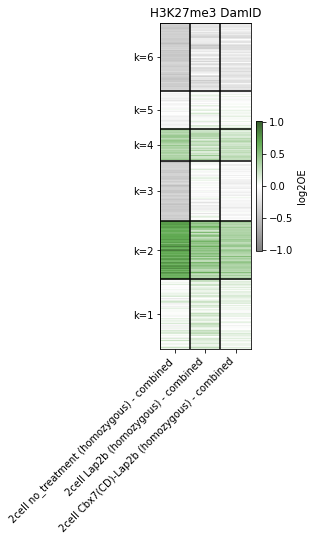

In [45]:
ind0 = (comb_anno.target=='H3K27me3') & (comb_anno.technique == 'DamID')
to_plot = comb_anno[ind0].copy()
alleles = ['combined']
plot_full_clustermap(to_plot, alleles, data_source=damid_insilico_logoe, damid_vals='log2OE', fancy_colors=True)
# plot_summarized_clustermap(to_plot, alleles, data_source=ext_data)

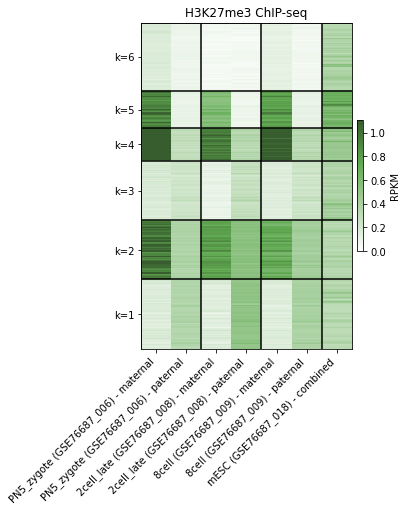

In [46]:
ind0 = (comb_anno.target=='H3K27me3') & (comb_anno.is_heterozygous | (comb_anno.stage=='mESC'))
ind1 = (comb_anno.treatment == 'no_treatment') & (comb_anno.dataset_id=='GSE76687')
ind2 = comb_anno.stage.isin(['PN5_zygote', '2cell_late', '8cell', 'mESC'])
to_plot = comb_anno[ind0 & ind1 & ind2].copy()
alleles = ['maternal','paternal']
plot_full_clustermap(to_plot, alleles, data_source=ext_data)
# plot_summarized_clustermap(to_plot, alleles, data_source=ext_data)

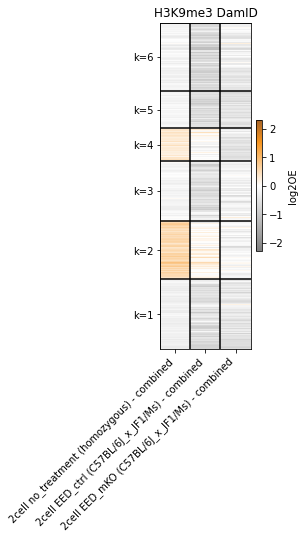

In [47]:
ind0 = (comb_anno.target=='H3K9me3') & (comb_anno.technique == 'DamID')
to_plot = comb_anno[ind0].copy()
alleles = ['combined']
plot_full_clustermap(to_plot, alleles, data_source=damid_insilico_logoe, damid_vals='log2OE')
# plot_summarized_clustermap(to_plot, alleles, data_source=ext_data)

## Plot diverse sample/color/allele combinations for external data

In [71]:
general_ind = (comb_anno.technique != 'DamID') & (comb_anno.target != 'input') & (comb_anno.treatment == 'no_treatment') 
stage_select_dict = {
    'all_stages': general_ind ,
    'main_stages': general_ind & comb_anno['stage'].isin(['zygote', 'PN3_zygote', 'PN5_zygote', '2cell', '2cell_late', '8cell', 'mESC'])
}

outfnfmt = FIGOUTDIR + 'clustermap.{target}.{dataset}.{stages}.samples_{control}.{alleles}.{version}_version.{colors}_colors.pdf'

for stageset, ind in stage_select_dict.items():
    
    for info, df in comb_anno[ind].groupby(['technique', 'target', 'dataset_id', 'has_control']):
        
        if (info[1] != 'H3K27ac'):
            continue
        
        # include Encode H3K9me3 sample in H3K9me3 dataset
        if (info[1] == 'H3K9me3') and (info[0] == 'ChIP-seq') and info[-1]:
            ind = comb_anno.index.isin(df.index) | (comb_anno.sample_id == 'EncodeHardison_001')
            df = comb_anno[ind].copy()
        
        for allele_view in ['combined_alleles', 'separate_alleles']:
        
            # generate out file name
            ctrl = 'with_inputcontrol' if info[-1] else 'without_inputcontrol'
            outfn = outfnfmt.format(
                target=info[1], dataset=info[2], stages=stageset, control=ctrl, alleles=allele_view, 
                version='full', colors='standard'
            )
            
            # select relevant samples
            if allele_view == 'combined_alleles':
                to_plot = df.copy()
                alleles = ['combined']
            else:
                to_plot = df[df.is_heterozygous | (df.stage == 'mESC')].copy()
                alleles = ['maternal', 'paternal']
            
            # continue if no (relevant) data is contained within the set
            if len(to_plot) == 0:
                continue
            elif (len(to_plot)==1) & (to_plot['stage'].values[0] == 'mESC'):
                continue
                
            # plot full version - standard colors
            plot_full_clustermap(to_plot, alleles, data_source=ext_data, fancy_colors=False)
            plt.savefig(outfn, bbox_inches='tight')
            plt.close()
            
            # plot summarized version - standard colors
            outfn_sum = outfn.replace('full_version', 'summary_version')
            plot_summarized_clustermap(to_plot, alleles, data_source=ext_data, fancy_colors=False)
            plt.savefig(outfn_sum, bbox_inches='tight')
            plt.close()
            
            # plot with fancy colors if available
            if info[1] in color_dict['target']:
                
                # plot full version - standard colors
                outfn = outfn.replace('standard_colors', 'fancy_colors')
                plot_full_clustermap(to_plot, alleles, data_source=ext_data, fancy_colors=True)
                plt.savefig(outfn, bbox_inches='tight')
                plt.close()

                # plot summarized version - standard colors
                outfn_sum = outfn.replace('full_version', 'summary_version')
                plot_summarized_clustermap(to_plot, alleles, data_source=ext_data, fancy_colors=True)
                plt.savefig(outfn_sum, bbox_inches='tight')
                plt.close()

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/2288753062.py:87: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/4068285315.py:95: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/2288753062.py:87: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/4068285315.py:95: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/2288753062.py:87: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/4068285315.py:95: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_7846/2288753062.py:87: 

## Plot DamID data - all conditions

In [213]:
alleles = ['combined', 'maternal', 'paternal']
outfnfmt = FIGOUTDIR + 'clustermap.DamID_{target}.all_conditions.{allele}.{norm}_values.{version}_version.{colors}_colors.pdf'


for target, df in comb_anno[(comb_anno.technique == 'DamID')].groupby('target'):
    print(df.shape)
    
    for allele_view in ['combined_alleles', 'separate_alleles']:
        
        if (not any(df.is_heterozygous)) and (allele_view == 'separate_alleles'):
            continue
        alleles = ['combined'] if allele_view == 'combined_alleles' else ['maternal', 'paternal']
        
        for norm in ['CF', 'log2OE']:

            for colors in ['standard', 'fancy']:

                dataset = contact_freq if norm == 'CF' else damid_insilico_logoe
                do_fancy = (colors == 'fancy')
                
                outfn = outfnfmt.format(
                    target = target, allele = allele_view, norm = norm, version = 'full',
                    colors = colors
                )
                print(outfn)
                
                # exclude H3K9me3 samples for which CF is not available
                if (target == 'H3K9me3') and (norm == 'CF'):
                    tmp = df[df.genotype=='homozygous'].copy()
                else:
                    tmp = df.copy()

                # plot full version - log2OE
                plot_full_clustermap(
                    tmp, alleles, data_source=dataset, 
                    damid_vals=norm, fancy_colors=do_fancy
                )
                plt.savefig(outfn, bbox_inches='tight')
                plt.close()
                
                # plot summarized version - log2OE
                plot_summarized_clustermap(
                    tmp, alleles, data_source=dataset, 
                    damid_vals=norm, fancy_colors=do_fancy
                )
                plt.savefig(outfn.replace('full_version','summary_version'), bbox_inches='tight')
                plt.close()

(1, 10)
(3, 10)
(3, 10)
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_H3K9me3.all_conditions.combined_alleles.CF_values.full_version.standard_colors.pdf


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/1082851803.py:161: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_func = matplotlib.cm.get_cmap(cmap)


../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_H3K9me3.all_conditions.combined_alleles.CF_values.full_version.fancy_colors.pdf
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_H3K9me3.all_conditions.combined_alleles.log2OE_values.full_version.standard_colors.pdf


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/1082851803.py:161: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_func = matplotlib.cm.get_cmap(cmap)


../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_H3K9me3.all_conditions.combined_alleles.log2OE_values.full_version.fancy_colors.pdf
(15, 10)
(3, 10)


## Plot DamID data - Lmnb1 separate conditions

In [109]:
alleles = ['combined', 'maternal', 'paternal']
outfnfmt = FIGOUTDIR + 'clustermap.DamID_Lmnb1.{experiment}.{allele}.{norm}_values.{version}_version.{colors}_colors.pdf'

general_ind = (comb_anno.target=='Lmnb1') & (comb_anno.technique=='DamID')
condition_ind_dict = {
    'homozygous_untreated': general_ind & ((~comb_anno.is_heterozygous) | (comb_anno.stage=='mESC')) & (comb_anno.treatment == 'no_treatment'),
    'hybrid_untreated': general_ind & comb_anno.is_heterozygous & (comb_anno.treatment == 'no_treatment'),
    'EED_experiment': general_ind & comb_anno.treatment.str.contains('EED'),
    'EED_vs_mESC': general_ind & (comb_anno.treatment.str.contains('EED') | (comb_anno.stage=='mESC')),
    'Cbx7-Lap2b_experiment_all': general_ind & comb_anno.stage.isin(['2cell','8cell']) & comb_anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b']),
    'Cbx7-Lap2b_experiment_homozygous': general_ind & (~comb_anno.is_heterozygous) & (comb_anno.stage=='2cell') & comb_anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b']),
    'Cbx7-Lap2b_experiment_hybrid': general_ind & comb_anno.is_heterozygous & comb_anno.stage.isin(['2cell','8cell']) & comb_anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b']),
    'alpha-amanitin': general_ind & (comb_anno.stage == '2cell') & (comb_anno.genotype == 'homozygous') & comb_anno.treatment.isin(['no_treatment', 'alpha-amanitin'])
}

for experiment_set, select_ind in condition_ind_dict.items():
    to_plot = comb_anno[select_ind].copy()

    for allele_view in ['combined_alleles', 'separate_alleles']:
        
        if (not any(to_plot.is_heterozygous)) and (allele_view == 'separate_alleles'):
            continue
        alleles = ['combined'] if allele_view == 'combined_alleles' else ['maternal', 'paternal']
        
        for norm in ['CF', 'log2OE']:
            
            if (experiment_set == 'EED_experiment_H3K9me3') and (norm == 'CF'):
                continue

            for colors in ['standard', 'fancy', 'BW']:

                dataset = contact_freq if norm == 'CF' else damid_insilico_logoe
                do_fancy = (colors == 'fancy')
                
                outfn = outfnfmt.format(
                    experiment = experiment_set, allele = allele_view, norm = norm, version = 'full',
                    colors = colors
                )
                print(outfn)

                cmap = 'binary' if colors == 'BW' else 'default'

                # plot full version
                plot_full_clustermap(
                    to_plot, alleles, data_source=dataset, 
                    damid_vals=norm, fancy_colors=do_fancy, cmap=cmap
                )
                plt.savefig(outfn, bbox_inches='tight')
                plt.close()

                # plot summarized version
                plot_summarized_clustermap(
                    to_plot, alleles, data_source=dataset, 
                    damid_vals=norm, fancy_colors=do_fancy, cmap=cmap
                )
                plt.savefig(outfn.replace('full_version','summary_version'), bbox_inches='tight')
                plt.close()


../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_vs_mESC.combined_alleles.CF_values.full_version.standard_colors.pdf
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_vs_mESC.combined_alleles.CF_values.full_version.fancy_colors.pdf
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_vs_mESC.combined_alleles.CF_values.full_version.BW_colors.pdf
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_vs_mESC.combined_alleles.log2OE_values.full_version.standard_colors.pdf
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/

In [223]:
outfnfmt = FIGOUTDIR + 'clustermap.DamID_Cbx1.{experiment}.{allele}.{norm}_values.{version}_version.{colors}_colors.pdf'

experiment_set = 'EED_experiment_H3K9me3'
select_ind = (comb_anno.target=='H3K9me3') & (comb_anno.technique=='DamID') & comb_anno.treatment.str.contains('EED')
allele_view = 'combined_alleles'
alleles = ['combined']
norm = 'log2OE'

to_plot = comb_anno[select_ind].copy()

for colors in ['standard', 'fancy', 'BW']:

    dataset = contact_freq if norm == 'CF' else damid_insilico_logoe
    do_fancy = (colors == 'fancy')

    outfn = outfnfmt.format(
        experiment = experiment_set, allele = allele_view, norm = norm, version = 'full',
        colors = colors
    )
    print(outfn)

    cmap = 'binary' if colors == 'BW' else 'default'

    # plot full version
    plot_full_clustermap(
        to_plot, alleles, data_source=dataset, 
        damid_vals=norm, fancy_colors=do_fancy, cmap=cmap, crange=[-1,1]
    )
    plt.savefig(outfn, bbox_inches='tight')
    plt.close()

    # plot summarized version
    plot_summarized_clustermap(
        to_plot, alleles, data_source=dataset, 
        damid_vals=norm, fancy_colors=do_fancy, cmap=cmap
    )
    plt.savefig(outfn.replace('full_version','summary_version'), bbox_inches='tight')
    plt.close()

../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_experiment_H3K9me3.combined_alleles.log2OE_values.full_version.standard_colors.pdf


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/1082851803.py:161: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_func = matplotlib.cm.get_cmap(cmap)


../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_experiment_H3K9me3.combined_alleles.log2OE_values.full_version.fancy_colors.pdf
../output/figures/5.2_Preimplantation.simplified_bin_clustering.part2.visualizing_clustered_heatmaps.allelic_bias_correction/clustermap.DamID_Lmnb1.EED_experiment_H3K9me3.combined_alleles.log2OE_values.full_version.BW_colors.pdf


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/1082851803.py:161: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_func = matplotlib.cm.get_cmap(cmap)


## Plotting differential Lmnb1 conditions - between conditions

In [52]:
from collections import defaultdict

In [72]:
def generate_diff_data_for_plotting(comparisons, metric):
    assert metric in ['log2OE', 'CF']
    diff_anno = defaultdict(list)
    diff_ds = {a: dict() for a in ['combined', 'maternal', 'paternal']}
    
    if metric == 'CF':
        data_source = contact_freq
    else:
        data_source = damid_insilico_logoe

    for A, B in comparisons:
        
        # generate sample id
        is_diff = np.array(A) != np.array(B)
        name_a = '_'.join(np.array(A)[is_diff])
        name_b = '_'.join(np.array(B)[is_diff])
        sample_id = name_a + '_vs_' + name_b
        diff_anno['sample_id'].append(sample_id)
        
        # generate samplesheet entries
        for i, col in enumerate(['target', 'stage', 'genotype', 'treatment']):
            if A[i] == B[i]:
                diff_anno[col].append(A[i])
            else:
                diff_anno[col].append(A[i] + '_vs_' + B[i])
                
        if (A[2] in GENOTYPE2PARENT) and (B[2] in GENOTYPE2PARENT):
            diff_anno['is_heterozygous'].append(True)
        else:
            diff_anno['is_heterozygous'].append(False)
        
        # add data
        for allele in ['combined', 'maternal', 'paternal']:
            
            if (A in data_source[allele]) and (B in data_source[allele]):
                diff_ds[allele][sample_id] = {c: data_source[allele][A][c] - data_source[allele][B][c] for c in chrom_order}

    diff_anno = pd.DataFrame(diff_anno)
    diff_anno['technique'] = 'DamID'
    diff_anno['control_id'] = 'none'
    diff_anno['dataset_id'] = 'Kind'
    diff_anno['has_control'] = False
    
    return diff_anno, diff_ds

In [73]:
all_comparisons = {
    0: [('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), 
     ('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')],
    
    1: [('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b'), 
     ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b')],
    
    2: [('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b'), 
     ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
    
    3: [('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), 
     ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b')],
    
    4: [('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), 
     ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
    
    5: [('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b'), 
     ('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
    
    6: [('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), 
     ('Dam-Lmnb1', 'zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
}

In [76]:
alleles = ['combined', 'maternal', 'paternal']
outfnfmt = FIGOUTDIR + 'clustermap.DamID_Lmnb1.DIFFERENTIAL.{experiment}.{allele}.{norm}_values.{version}_version.pdf'

comparison_dict = {
    'all_treatments': [all_comparisons[x] for x in range(6)],
    'all_treatments_2cell': [all_comparisons[x] for x in range(5)],
    'EED_mKO_vs_ctrl': [all_comparisons[0]],
    '2cell_Cbx7-Lap2b': [all_comparisons[x] for x in range(1,5)],
    '8cell_Cbx7-Lap2b': [all_comparisons[5]],
    '2-8cell_Cbx7-Lap2b': [all_comparisons[x] for x in range(1,6)],
    'zygote_vs_2cell': [all_comparisons[6]]
}


for experiment_set, comparison_ls in comparison_dict.items():

    for allele_view in ['combined_alleles', 'separate_alleles']:
        
        alleles = ['combined'] if allele_view == 'combined_alleles' else ['maternal', 'paternal']
        
        for norm in ['CF', 'log2OE']:

            diff_anno, diff_ds = generate_diff_data_for_plotting(comparison_ls, norm)
            if allele_view == 'separate_alleles':
                diff_anno = diff_anno[diff_anno.is_heterozygous]

            outfn = outfnfmt.format(
                experiment = experiment_set, allele = allele_view, norm = norm, version = 'full'
            )

            # plot full version
            plot_full_clustermap(diff_anno, alleles, data_source=diff_ds, damid_vals=norm, cmap='PuOr_r')
            plt.savefig(outfn, bbox_inches='tight')
            plt.close()

            # plot summarized version
            plot_summarized_clustermap(diff_anno, alleles, data_source=diff_ds, damid_vals=norm, cmap='PuOr_r')
            plt.savefig(outfn.replace('full_version','summary_version'), bbox_inches='tight')
            plt.close()


## Plotting differential Lmnb1 conditions - between alleles

In [79]:
metric = 'log2OE'
diff_anno = comb_anno[(comb_anno.target=='Lmnb1')&comb_anno.is_heterozygous].copy()
diff_ds = {'combined': dict()}

if metric == 'CF':
    data_source = contact_freq
else:
    data_source = damid_insilico_logoe

for _, row in diff_anno.iterrows():

    condition = row['sample_id']
    diff_ds['combined'][condition] = {c: data_source['maternal'][condition][c] - data_source['paternal'][condition][c] for c in chrom_order}

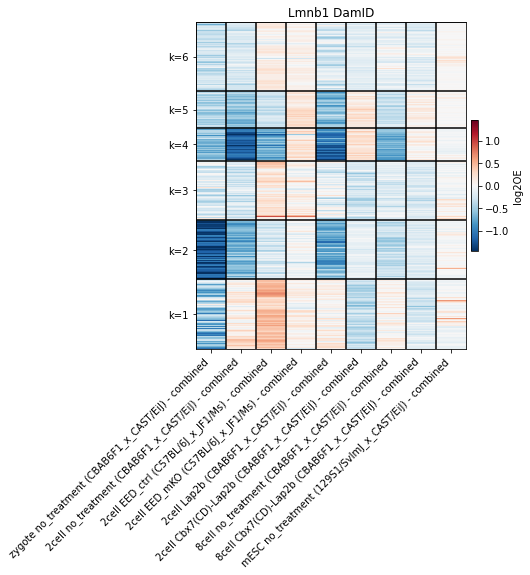

In [80]:
plot_full_clustermap(diff_anno, ['combined'], data_source=diff_ds, damid_vals='log2OE', cmap='RdBu_r', fancy_colors=False)
# plt.savefig(outfn, bbox_inches='tight')
# plt.close()

In [83]:
to_plot = {
    '2cell_all_treatments': (diff_anno.stage=='2cell'),
    '2cell_EED': (diff_anno.treatment.str.contains('EED')),
    '2cell_Cbx7Lap2b': (diff_anno.stage=='2cell') & diff_anno.treatment.isin(['Lap2b', 'Cbx7(CD)-Lap2b']),
    '2cell_EED_Cbx7Lap2b': (diff_anno.stage=='2cell') & diff_anno.treatment.isin(['EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b']),
    'all_stages_and_conditions': (diff_anno.stage==diff_anno.stage),
    'all_stages_untreated': (diff_anno.treatment == 'no_treatment'),
    'all_stages_Cbx7Lap2b': diff_anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b']),
}

outfnfmt = FIGOUTDIR + 'clustermap.DamID_Lmnb1.ALLELIC_DIFFERENTIAL.{name}.{norm}_values.{version}_version.pdf'


for name, select_ind in to_plot.items():
    outfn = outfnfmt.format(
        name = name, norm = norm, version = 'full'
    )

    # plot full version
    plot_full_clustermap(diff_anno[select_ind], ['combined'], data_source=diff_ds, damid_vals=metric, cmap='RdBu_r', fancy_colors=False)
    plt.savefig(outfn, bbox_inches='tight')
    plt.close()

    # plot summarized version
    plot_summarized_clustermap(diff_anno[select_ind], ['combined'], data_source=diff_ds, damid_vals=metric, cmap='RdBu_r', fancy_colors=False)
    plt.savefig(outfn.replace('full_version','summary_version'), bbox_inches='tight')
    plt.close()

## A/T content in clustermap

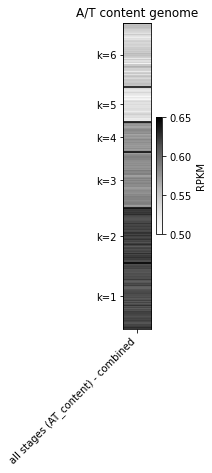

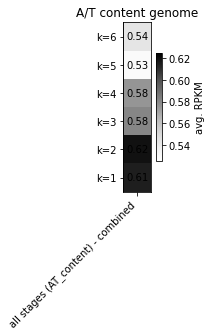

In [108]:
tmp = pd.DataFrame({
    'target': 'A/T content', 'sample_id': 'AT_content', 'control_id': 'none', 'dataset_id': 'genome', 'has_control': False,
    'technique': 'genome', 'is_heterozygous': False, 'treatment': 'no_treatment', 'stage': 'all stages'
    
}, index=[0])

tmp_ds = {'combined': {'AT_content': at_content}}

cmap = 'Greys'


plot_full_clustermap(tmp, ['combined'], data_source=tmp_ds, cmap=cmap, fancy_colors=False, crange=[0.5,0.65])
outfn = FIGOUTDIR + 'ATcontent.clustered_heatmap.full_version.pdf'
plt.savefig(outfn, bbox_inches='tight')

plot_summarized_clustermap(tmp, ['combined'], data_source=tmp_ds, cmap=cmap, fancy_colors=False, crange=[0.525,0.625])
outfn = outfn.replace('full_version', 'summary_version')
plt.savefig(outfn, bbox_inches='tight')

## 5.5 Function to plot enrichment in clusters as violin plots

In [86]:
def plot_violins_of_clusters(to_plot, allele, damid_vals='CF'):
    
    PERFORM_ALLELE_CORRECTION = True
    
    # select only hybrid data for allele-specific plot
    if allele != 'combined':
        to_plot = to_plot[to_plot.is_heterozygous]
    to_plot = to_plot[to_plot.target != 'input']
    if len(to_plot) == 0:
        return

    # group data
    groupkeys = ['technique', 'target', 'dataset_id', 'has_control']
    g_to_plot = to_plot.groupby(groupkeys)

    # set-up figure layout
    wr = [len(df) for _, df in g_to_plot]
    ncol = len(wr)
    nrow = len(np.unique(cluster_lin))
    fig, axes = plt.subplots(nrow, ncol, figsize=(sum(wr), 2*nrow), gridspec_kw={'width_ratios': wr})
    plt.subplots_adjust(wspace=.6, hspace=.1)
    c_counter = 0

    # iterate over different datasets and plot per cluster
    for info, df in g_to_plot:

        data_to_plot = dict()
        data_to_plot['K'] = cluster_lin

        # collect the data for the different stages
        df = df.copy().sort_values(by='stage')
        sample_order = list()

        for _, row in df.iterrows():

            sample_id = row['sample_id']
            control_id = row['control_id']
            has_control = info[-1]
            technique = row['technique']

            if technique == 'DamID':
                if damid_vals == 'CF':
                    C = np.concatenate([contact_freq[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])
                    ylab = 'CF'
                else:
                    C = np.concatenate([damid_insilico_logoe[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])
                    ylab = 'log2OE'

                lab = '%s - %s (%s)' % (row['stage'], row['treatment'], row['genotype'])

            else:
                C = np.concatenate([ext_data[allele][sample_id][c][bin_select[c]] for c in cluster_chroms])

                test = (sample_id in ext_data['allele_vis']) & (row['dataset_id'] != 'GSE56697')
                if has_control:
                    Cctrl = np.concatenate([ext_data[allele][control_id][c][bin_select[c]] for c in cluster_chroms])
                    C = np.log2( (C + 0.1) / (Cctrl + 0.1) )
                    ylab = 'log2OE'
                
                elif (allele != 'combined') & test & PERFORM_ALLELE_CORRECTION:
                    Cav = np.concatenate([ext_data['allele_vis'][sample_id][c][bin_select[c]] for c in cluster_chroms])
                    C = C / Cav
                    ylab = 'RPKM'
                
                elif info[1] in ['MethylC-Seq', 'TAB-seq', 'fCAB-seq']:
                    ylab = 'fraction CpG'
                
                else:
                    ylab = 'RPKM'

                lab = '%s - %s (%s)' % (row['stage'], row['treatment'], row['sample_id'])

            # set unmappable/blacklisted/non-allele resolved bins to nan
            if info[0] == 'DamID':
                m_ind = np.concatenate([mapab[c][bin_select[c]] for c in cluster_chroms]) > MINMAP

                if allele != 'combined':
                    a_ind = np.concatenate([allele_filt_gt[row['genotype']][c][bin_select[c]] for c in cluster_chroms])
                    filt_ind = m_ind & a_ind
                else:
                    filt_ind = m_ind
            else:
                b_ind = ~np.concatenate([ext_data['blacklisted'][c][bin_select[c]] for c in cluster_chroms])

                if (allele != 'combined') and (sample_id in ext_data['allele_vis']):
                    a_ind = np.concatenate([ext_data['allele_vis'][sample_id][c][bin_select[c]] for c in cluster_chroms]) > .1
                    filt_ind = b_ind & a_ind
                else:
                    filt_ind = b_ind

            C[~filt_ind] = np.nan

            data_to_plot[lab] = C
            sample_order.append(lab)

        data_to_plot = pd.DataFrame(data_to_plot)
        data_to_plot = data_to_plot.melt(id_vars='K', var_name='stage', value_name='value')

        # iterate over clusters and plot violins

        for irow, k in enumerate(np.sort(np.unique(cluster_lin))):
            ax = axes[irow, c_counter] if ncol > 1 else axes[irow]

            # set title
            title = '%s - %s\n(%s)' % (info[0], info[1], info[2])
            if irow == 0:
                ax.set_title(title)
            ax.text(0.05, 0.95, 'k=%d' % k, ha='left', va='top', transform=ax.transAxes)

            # plot data
            df_k = data_to_plot.loc[data_to_plot['K'] == k,:].copy()
            clr = color_dict['target'][info[1]] if info[1] in color_dict['target'] else 'lightgrey'
            sns.violinplot(
                x=df_k['stage'], y=df_k['value'], 
                ax=ax, order=sample_order, color=clr, cut=0
            )

            # format
            ax.set_ylabel(ylab)
            ax.set_xticks(ax.get_xticks())
            labs = [t.get_text() for t in ax.get_xticklabels()]
            ax.set_xticklabels(labs, rotation=45, ha='right')
            ax.set_xlabel('')
            if irow < (nrow - 1):
                ax.set_xticklabels(['' for _ in sample_order])

            # set ylimits to not accommodate outliers
            yranges = list()
            for _, tmp in df_k.groupby('stage'):
                m = np.nanmean(tmp['value'].values)
                s = np.nanstd(tmp['value'].values)
                yranges.append([m-3*s, m+4*s])
            yranges = np.array(yranges)
            yranges = [yranges.min(axis=0)[0], yranges.max(axis=0)[1]]
            ylim_new = [max(yranges[0], ax.get_ylim()[0]), min(yranges[1], ax.get_ylim()[1])]
            ax.set_ylim(ylim_new)

        c_counter += 1

## 5.6 Example violin plots for selected stages

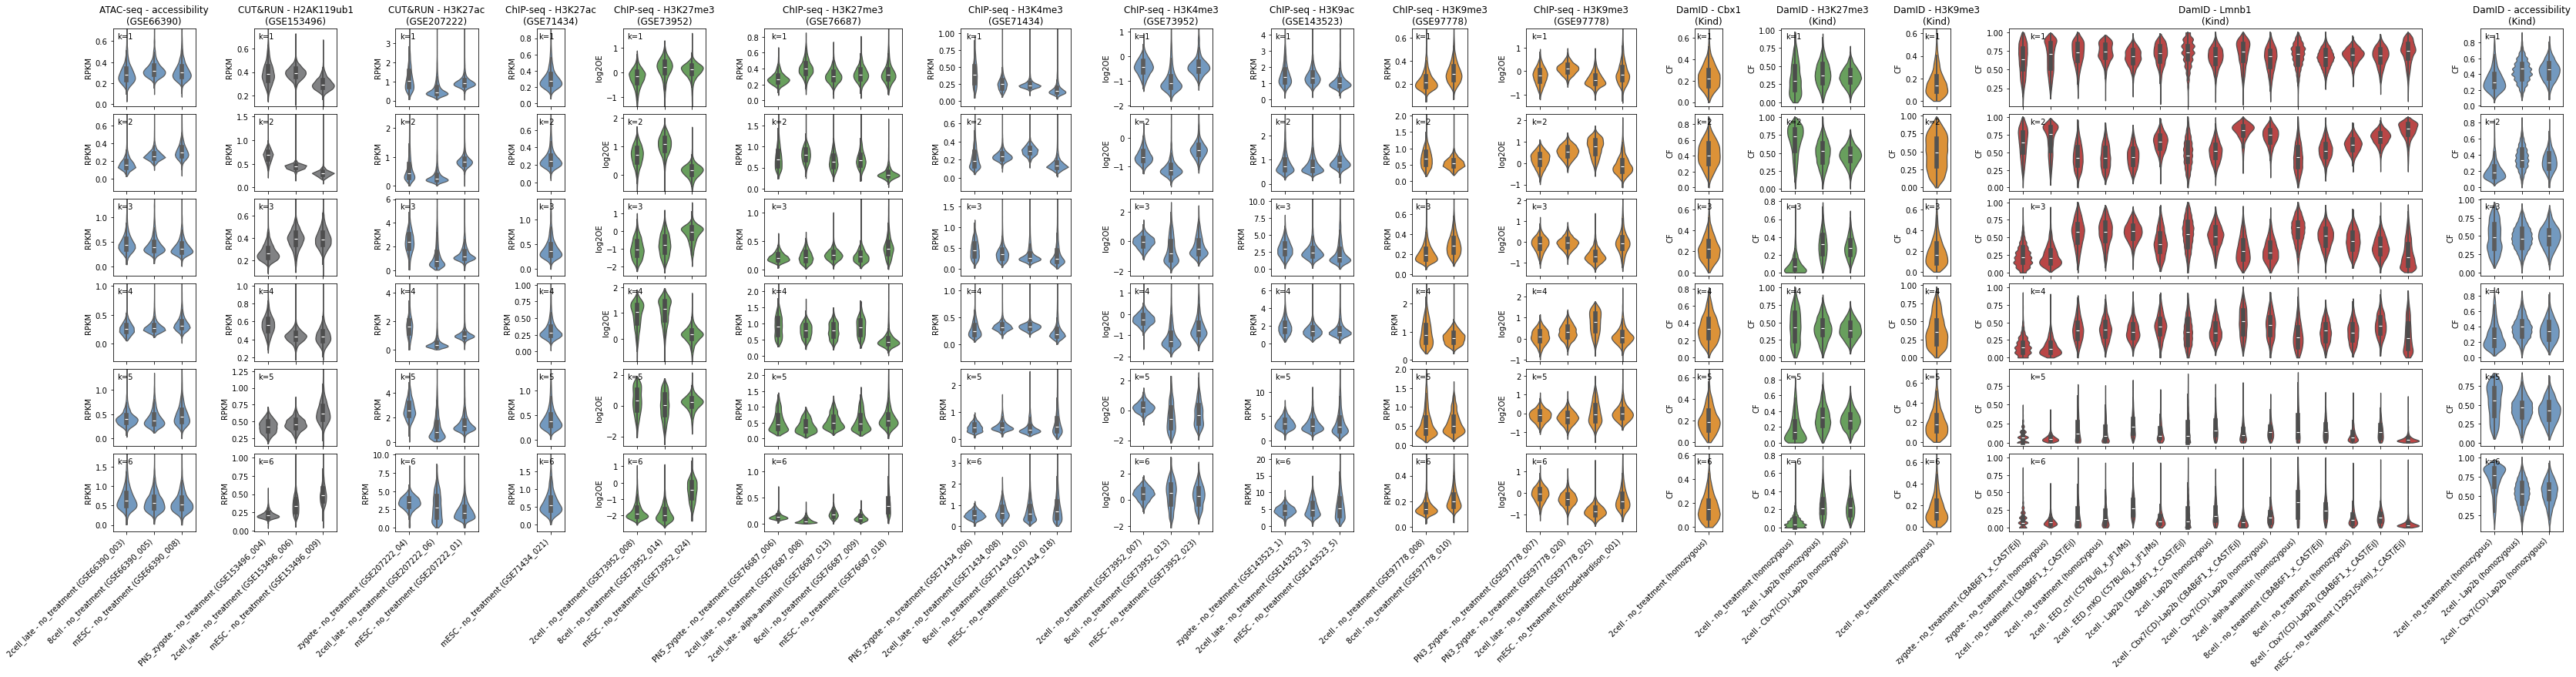

In [112]:
tmp = ['zygote', 'PN3_zygote', 'PN5_zygote', 'zygote', '2cell', '2cell_late', '8cell', 'mESC']
to_plot = comb_anno[comb_anno.stage.isin(tmp)].copy()
to_plot.loc[(to_plot.target == 'H3K9me3') & (to_plot.dataset_id == 'Encode_Hardison'), 'dataset_id'] = 'GSE97778'
to_plot = to_plot[~((to_plot.target=='H3K9me3') & to_plot.treatment.str.contains('EED'))]
allele = 'combined'
damid_vals = 'CF'

plot_violins_of_clusters(to_plot, allele, damid_vals='CF')

## 5.7 Saving violinplots for different sample subsets and alleles

In [113]:
excl1 = ~(comb_anno.treatment.str.contains('EED') & (comb_anno.target != 'Lmnb1'))
excl2 = (comb_anno.target != 'input')
excl = excl1 & excl2
stage_subsets = {
    'all_stages': excl,
    'matched_stages': excl & comb_anno.stage.isin(['zygote', 'PN3_zygote', 'PN5_zygote', 'zygote', '2cell', '2cell_late', '8cell', 'mESC'])
}

outfmt = FIGOUTDIR + 'cluster_violins.{target}.{stages}.{allele}.pdf'

for allele in ['maternal', 'paternal', 'combined']:
    
    allele_name = 'combined_alleles' if allele=='combined' else '%s_allele' % allele
    
    for stageset_name, stage_ind in stage_subsets.items():
        
        for target, to_plot in comb_anno[stage_ind].groupby('target'):
            
            to_plot = to_plot.copy()
            if allele != 'combined':
                to_plot = to_plot[to_plot.is_heterozygous]
            if len(to_plot) == 0:
                continue
            if target == 'H3K9me3':
                to_plot.loc[(to_plot.dataset_id == 'Encode_Hardison'), 'dataset_id'] = 'GSE97778'
                
            print(allele, stageset_name, target)
                
            # format filename
            outfn = outfmt.format(target=target, stages=stageset_name, allele=allele_name)
                
            if any(to_plot['technique'] == 'DamID'):
                
                for damid_vals in ['CF', 'log2OE']:
                    
                    outfn2 = outfn.replace('.pdf', '.DamID_as_%s.pdf' % damid_vals)
                    plot_violins_of_clusters(to_plot, allele, damid_vals=damid_vals)
                    plt.savefig(outfn2, bbox_inches='tight')
                    plt.close()
                
            else:
                plot_violins_of_clusters(to_plot, allele, damid_vals='CF')
                plt.savefig(outfn, bbox_inches='tight')
                plt.close()

maternal all_stages 5fCpG
maternal all_stages 5mCpG
maternal all_stages 5mhCpG
maternal all_stages H2AK119ub1
maternal all_stages H3K27ac


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


maternal all_stages H3K27me3


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


maternal all_stages H3K4me3
maternal all_stages H3K9me3
maternal all_stages Lmnb1
maternal all_stages accessibility


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


maternal matched_stages H2AK119ub1
maternal matched_stages H3K27ac


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


maternal matched_stages H3K27me3


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


maternal matched_stages H3K4me3
maternal matched_stages H3K9me3
maternal matched_stages Lmnb1
maternal matched_stages accessibility


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


paternal all_stages 5fCpG
paternal all_stages 5mCpG
paternal all_stages 5mhCpG
paternal all_stages H2AK119ub1
paternal all_stages H3K27ac


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


paternal all_stages H3K27me3


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


paternal all_stages H3K4me3
paternal all_stages H3K9me3
paternal all_stages Lmnb1
paternal all_stages accessibility


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


paternal matched_stages H2AK119ub1
paternal matched_stages H3K27ac


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


paternal matched_stages H3K27me3


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


paternal matched_stages H3K4me3
paternal matched_stages H3K9me3
paternal matched_stages Lmnb1
paternal matched_stages accessibility


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_68015/4064269055.py:62: RuntimeWarning: invalid value encountered in true_divide
  C = C / Cav


combined all_stages 5fCpG
combined all_stages 5mCpG
combined all_stages 5mhCpG
combined all_stages Cbx1
combined all_stages H2AK119ub1
combined all_stages H3K27ac
combined all_stages H3K27me3
combined all_stages H3K4me3
combined all_stages H3K9ac
combined all_stages H3K9me3
combined all_stages Lmnb1
combined all_stages accessibility
combined matched_stages Cbx1
combined matched_stages H2AK119ub1
combined matched_stages H3K27ac
combined matched_stages H3K27me3
combined matched_stages H3K4me3
combined matched_stages H3K9ac
combined matched_stages H3K9me3
combined matched_stages Lmnb1
combined matched_stages accessibility


# 6. Enrichment of genes in clusters

In [52]:
cluster_chroms = bin_clusters['chrom'].unique()
bin_select = {c: df['bin_ind'].values for c, df in bin_clusters.groupby('chrom')}
cluster_lin = bin_clusters['Kcluster'].values
cluster_uniq = bin_clusters['Kcluster'].sort_values().unique()
k_order = np.argsort(cluster_lin)
n_bins_per_k = np.array([(cluster_lin == k).sum() for k in np.sort(np.unique(cluster_lin))])

In [53]:
def plot_patches(C, vrange, cmap, ax):
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            val = C[i,j]
            clrval = (val - vrange[0]) / (vrange[1] - vrange[0])
            R = matplotlib.patches.Rectangle((j,i), 1, 1, color=cmap(clrval), lw=0)
            ax.add_patch(R)

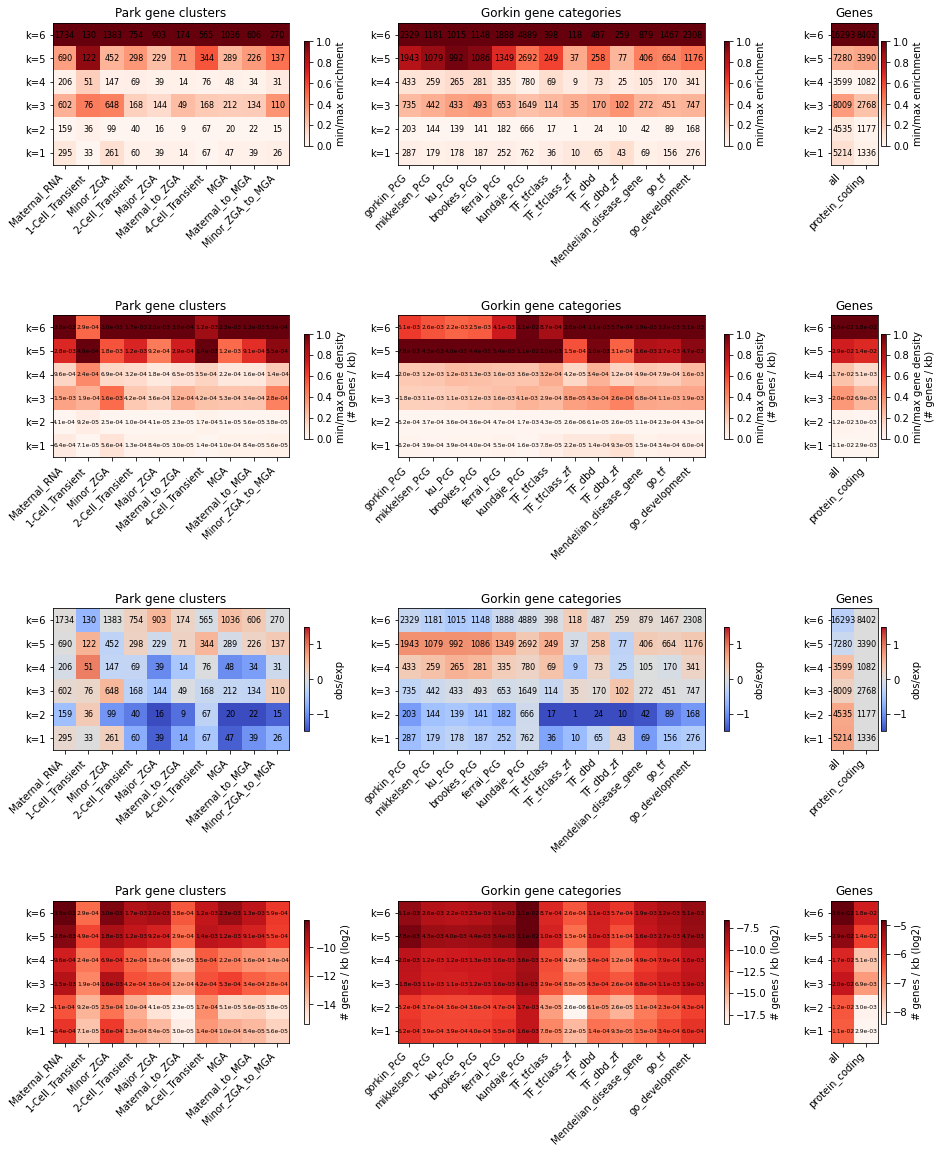

In [58]:
tmp = {
    'Park gene clusters': park_gene_density, 
    'Gorkin gene categories': gorkin_gene_density,
    'Genes': gene_density
}

wr = [len(v.keys()) for v in tmp.values()]

fig, axes = plt.subplots(4,len(wr),figsize=(15,20), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(hspace=.4)
counter = 0

# determine the expected gene distributions
expected = np.concatenate([gene_density['protein_coding'][c][bin_select[c]] for c in cluster_chroms])
expected = pd.DataFrame({'N': expected, 'K': cluster_lin})
expected = expected.groupby('K').sum()
expected = expected['N'].values / expected['N'].values.sum()
expected = np.reshape(expected, (len(expected), 1))

for title, target_gene_density in tmp.items():
    ax0 = axes[0,counter]
    ax1 = axes[1,counter]
    ax2 = axes[2,counter]
    ax3 = axes[3,counter]
    counter += 1
    
    x = 0

    D = dict()
    for geneset in target_gene_density:
        density = target_gene_density[geneset]
        d = np.concatenate([density[c][bin_select[c]] for c in cluster_chroms])
        D[geneset] = d
        
    # number of genes in each category per cluster
    D = pd.DataFrame(D)
    D['K'] = cluster_lin
    Ddensity = D.copy().groupby('K').mean() / BINSIZE * 1000 # N per kb
    D = D.groupby('K').sum()
    
    
    # min-max scaling of number of genes per cluster
    D_scaled = D.copy()
    mn = D_scaled.min(axis=0).values
    mn = np.reshape(mn, (1, len(mn)))
    mx = (D_scaled - mn).max().values
    mx = np.reshape(mx, (1, len(mx)))
    D_scaled = (D_scaled - mn) / mx
    
    # min-max scaling of gene density per cluster
    D_scaled_d = Ddensity.copy()
    mn = D_scaled_d.min(axis=0).values
    mn = np.reshape(mn, (1, len(mn)))
    mx = (D_scaled_d - mn).max().values
    mx = np.reshape(mx, (1, len(mx)))
    D_scaled_d = (D_scaled_d - mn) / mx
    
    # compute observed/expected number of genes
    D_oe = D.copy()
    t = D_oe.sum(axis=0).values
    t = np.reshape(t, (1, len(t)))
    D_oe = (D_oe / t) / expected

    # plot min-max scaled number of genes
    p = ax0.imshow(D_scaled, 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1
             )
    cbar = plt.colorbar(p, ax=ax0, shrink=.5)
    cbar.ax.set_ylabel('min/max enrichment')
    
    plot_patches(D_scaled.values, [0, 1], matplotlib.colormaps.get_cmap('Reds'), ax0)
    p.remove()
    
    # plot min-max scaled gene density
    p = ax1.imshow(D_scaled_d, 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1
             )
    cbar = plt.colorbar(p, ax=ax1, shrink=.5)
    cbar.ax.set_ylabel('min/max gene density\n(# genes / kb)')
    
    plot_patches(D_scaled_d.values, [0, 1], matplotlib.colormaps.get_cmap('Reds'), ax1)
    p.remove()
    
    # plot oe enrichment
    p = ax2.imshow(np.log2(D_oe), 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='coolwarm', vmin=-1.5, vmax=1.5
             )
    cbar = plt.colorbar(p, ax=ax2, shrink=.5)
    cbar.ax.set_ylabel('obs/exp')
    
    plot_patches(np.log2(D_oe).values, [-1.5, 1.5], matplotlib.colormaps.get_cmap('coolwarm'), ax2)
    p.remove()
    
    # plot log density enrichment
    Dlog = np.log2(Ddensity.copy())
    mn = Dlog.values.min()
    mx = Dlog.values.max()
    p = ax3.imshow(Dlog, 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='Reds', vmin=mn, vmax=mx
             )
    cbar = plt.colorbar(p, ax=ax3, shrink=.5)
    cbar.ax.set_ylabel('# genes / kb (log2)')
    
    plot_patches(Dlog.values, [mn, mx], matplotlib.colormaps.get_cmap('Reds'), ax3)
    p.remove()
    
    for ax in [ax0, ax1, ax2, ax3]:
        ax.set_xlim(0, D.shape[1])
        ax.set_xticks(np.arange(D.shape[1]) + .5)
        ax.set_xticklabels(D.columns, rotation=45, ha='right')
        ax.set_title(title)
        ax.set_aspect('equal')

        ax.set_yticks(np.arange(D.shape[0])+.5)
        ax.set_yticklabels(['k=%d' % k for k in cluster_uniq])

        for y in range(D.shape[0]):
            for x in range(D.shape[1]):
                
                if ax in [ax1,ax3]:
                    n = Ddensity.iloc[y, x]
                    t = '%.1e' % n
                    ax.text(x+.5, y+.5, t, ha='center', va='center', fontsize=6)
                else:
                    n = D.iloc[y, x]
                    t = '%d' % n
                    ax.text(x+.5, y+.5, t, ha='center', va='center', fontsize=8)
                
                
outfn = FIGOUTDIR + 'GENES.clustered_heatmap.number_and_enrichment_of_gene_categories_in_clusters.pdf'
plt.savefig(outfn, bbox_inches='tight')

# 7. Number of repeats per cluster

## 7.1 Number of repeat copies per family in each cluster

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


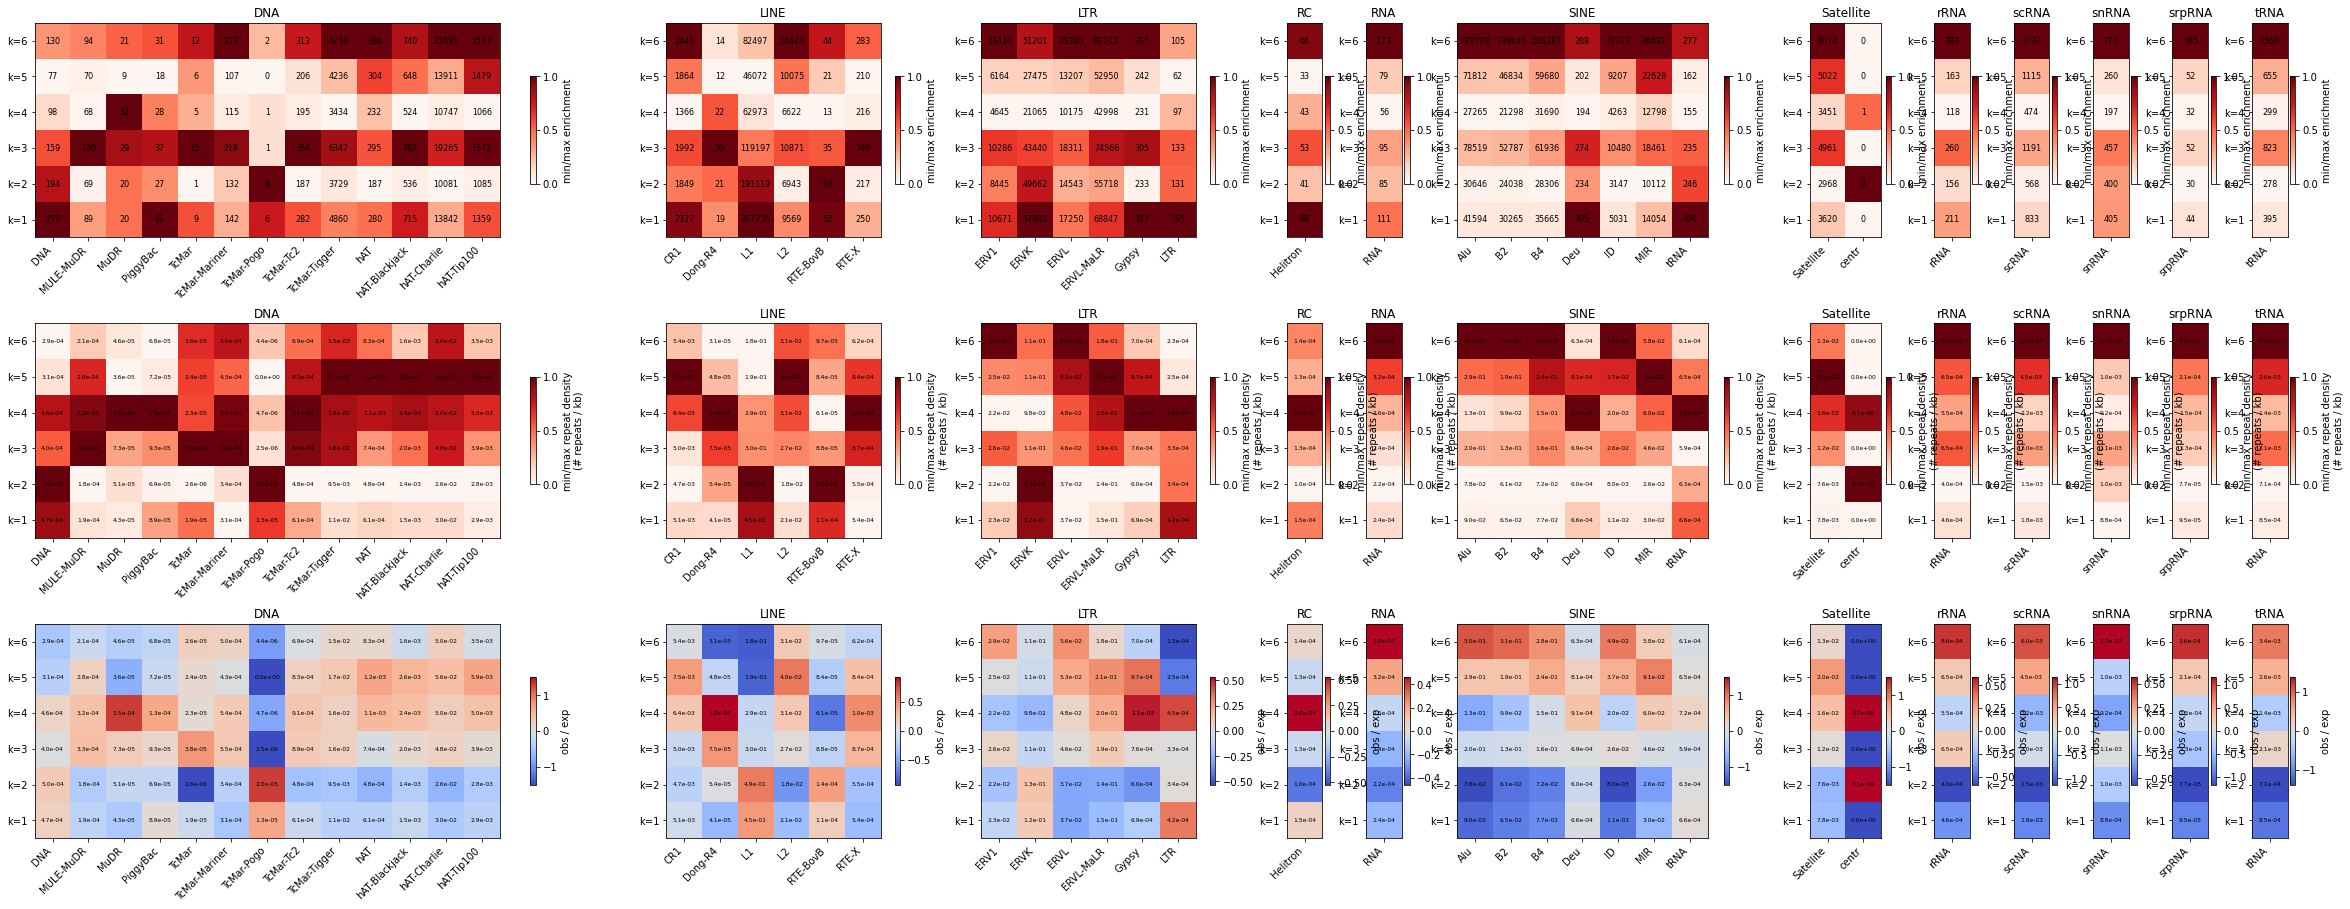

In [72]:
rep_to_plot = repeats.groupby(['repClass', 'repFamily'])
repclasses = repeats.repClass.sort_values().unique()

wr = [len(repeats.loc[repeats.repClass == c, 'repFamily'].unique()) for c in repclasses]

fig, axes = plt.subplots(3,len(wr),figsize=(sum(wr),15), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(hspace=.4)
counter = 0

for icol, repclass in enumerate(repclasses):
    ax0 = axes[0,icol]
    ax1 = axes[1,icol]
    ax2 = axes[2,icol]
    
    repfams = repeats.loc[repeats.repClass == repclass, 'repFamily'].sort_values().unique()
    
    D = dict()
    for repfam in repfams:
        setname = (repclass, repfam)
        
        density = repeat_density[setname]
        d = np.concatenate([density[c][bin_select[c]] for c in cluster_chroms])
        D[repfam] = d
        
    # determine total number of repeats per cluster
    D = pd.DataFrame(D)
    Ddensity_whole_genome = np.nanmean(D, axis=0) / BINSIZE * 1000
    D['K'] = cluster_lin
    Ddensity = D.copy().groupby('K').mean() / BINSIZE * 1000 # n repeats per kb
    D = D.groupby('K').sum()
    
    # min-max scaling of repeats per cluster
    D_scaled = D.copy()
    mn = D_scaled.min(axis=0).values
    mn = np.reshape(mn, (1, len(mn)))
    mx = (D_scaled - mn).max().values
    mx = np.reshape(mx, (1, len(mx)))
    D_scaled = (D_scaled - mn) / mx
    
    # min-max scaling of repeat density per cluster
    D_scaled_d = Ddensity.copy()
    mn = D_scaled_d.min(axis=0).values
    mn = np.reshape(mn, (1, len(mn)))
    mx = (D_scaled_d - mn).max().values
    mx = np.reshape(mx, (1, len(mx)))
    D_scaled_d = (D_scaled_d - mn) / mx
    
    # obs/exp of repeat density per cluster
    Doe = np.log2( Ddensity.copy() / Ddensity_whole_genome.copy() )
    
    # plot min-max scaled number of repeats
    p = ax0.imshow(D_scaled, 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1
             )
    cbar = plt.colorbar(p, ax=ax0, shrink=.5, ticks=[0,.5,1])
    cbar.ax.set_ylabel('min/max enrichment')
    
    plot_patches(D_scaled.values, [0, 1], matplotlib.colormaps.get_cmap('Reds'), ax0)
    p.remove()
    
    # plot min-max scaled repeat density
    p = ax1.imshow(D_scaled_d, 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1
             )
    cbar = plt.colorbar(p, ax=ax1, shrink=.5, ticks=[0,.5,1])
    cbar.ax.set_ylabel('min/max repeat density\n(# repeats / kb)')
    
    plot_patches(D_scaled_d.values, [0, 1], matplotlib.colormaps.get_cmap('Reds'), ax1)
    p.remove()
    
    # plot logOE of repeats per cluster
    vals = Doe.values.flatten()
    mx = abs(vals[~(np.isinf(vals)|np.isnan(vals))]).max()
    mx = min(mx,1.5)
    p = ax2.imshow(Doe, 
              extent=[0, D.shape[1], 0, D.shape[0]], 
              aspect='auto', origin='lower', cmap='coolwarm', vmin=-mx, vmax=mx
             )
    cbar = plt.colorbar(p, ax=ax2, shrink=.5)
    cbar.ax.set_ylabel('obs / exp')
    
    plot_patches(Doe.values, [-mx, mx], matplotlib.colormaps.get_cmap('coolwarm'), ax2)
    p.remove()
    
    for ax in [ax0, ax1, ax2]:
        ax.set_title(repclass)

        ax.set_xlim(0, D.shape[1])
        ax.set_xticks(np.arange(D.shape[1]) + .5)
        ax.set_xticklabels(D.columns, rotation=45, ha='right')
        ax.set_aspect('equal')
        ax.set_yticks(np.arange(0, D.shape[0])+.5)
        ax.set_yticklabels(['k=%d' % k for k in cluster_uniq])

        for y in range(D.shape[0]):
            for x in range(D.shape[1]):
                
                if ax == ax0:
                    n = D.iloc[y, x]
                    t = '%d' % n
                    ax.text(x+.5, y+.5, t, ha='center', va='center', fontsize=8)
                else:
                    n = Ddensity.iloc[y, x]
                    t = '%.1e' % n
                    ax.text(x+.5, y+.5, t, ha='center', va='center', fontsize=6)
            
outfn = FIGOUTDIR + 'REPEATS.clustered_heatmap.number_of_repeat_copies_in_clusters.per_repClass_and_repFamily.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 7.2 Function to plot number of repeats per cluster

In [86]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [87]:
def plot_repeatfam_summary(repclass, min_n):
    
    rep_to_plot = repeats[(repeats.repClass == repclass)].copy()
    rm_reps = list()
    for (repfam, rep), _ in rep_to_plot.groupby(['repFamily', 'repName']):
        if (repclass, repfam, rep) not in repeat_density:
            rm_reps.append(rep)
    rep_to_plot = rep_to_plot[~rep_to_plot.repName.isin(rm_reps)]
    tmp = rep_to_plot.groupby(['repFamily', 'repName']).size()
    tmp = tmp[tmp > min_n].reset_index()
    rep_to_plot = rep_to_plot[rep_to_plot.repName.isin(tmp.repName)]

    repfams = rep_to_plot.repFamily.sort_values().unique()
    print(repfams)
    
    if len(repfams) == 0:
        return

    wr = [len(rep_to_plot.loc[repeats.repFamily == repfam, 'repName'].unique()) for repfam in repfams]
    print(wr)
    
    fig, axes = plt.subplots(3,len(wr),figsize=(sum(wr)*.4,15), gridspec_kw={'width_ratios': wr})
    plt.subplots_adjust(hspace=.4)
    counter = 0

    for icol, repfam in enumerate(repfams):
        ax0 = axes[0,icol] if len(wr) > 1 else axes[0]
        ax1 = axes[1,icol] if len(wr) > 1 else axes[1]
        ax2 = axes[2,icol] if len(wr) > 1 else axes[2]
        
        reps = rep_to_plot.loc[rep_to_plot.repFamily == repfam, 'repName'].sort_values().unique()
        D = dict()
        for rep in reps:
            setname = (repclass, repfam, rep)
            density = repeat_density[setname]
            d = np.concatenate([density[c][bin_select[c]] for c in cluster_chroms])
            D[rep] = d

        # determine total number of repeats per cluster
        D = pd.DataFrame(D)
        Ddensity_whole_genome = np.nanmean(D, axis=0) / BINSIZE * 1000
        D['K'] = cluster_lin
        Ddensity = D.copy().groupby('K').mean() / BINSIZE * 1000 # n repeats per kb
        D = D.groupby('K').sum()

        # min-max scaling of repeats per cluster
        D_scaled = D.copy()
        mn = D_scaled.min(axis=0).values
        mn = np.reshape(mn, (1, len(mn)))
        mx = (D_scaled - mn).max().values
        mx = np.reshape(mx, (1, len(mx)))
        D_scaled = (D_scaled - mn) / mx
        D_scaled[np.isinf(D_scaled)] = 0
        D_scaled[np.isnan(D_scaled)] = 0
        
        # min-max scaling of repeat density per cluster
        D_scaled_d = Ddensity.copy()
        mn = D_scaled_d.min(axis=0).values
        mn = np.reshape(mn, (1, len(mn)))
        mx = (D_scaled_d - mn).max().values
        mx = np.reshape(mx, (1, len(mx)))
        D_scaled_d = (D_scaled_d - mn) / mx
        D_scaled_d[np.isinf(D_scaled_d)] = 0
        D_scaled_d[np.isnan(D_scaled_d)] = 0
        
        # obs/exp of repeat density per cluster
        Doe = np.log2( Ddensity.copy() / Ddensity_whole_genome.copy() )

        # cluster columns
        if Doe.shape[1] > 2:
            vals = Doe.values.flatten()
            mx = abs(vals[~(np.isinf(vals)|np.isnan(vals))]).max()
            mx = min(mx,1.5)
            linkage = hc.linkage(Doe.fillna(0).T.clip(-mx,mx), method='average')
            order = hc.leaves_list(linkage)
            cols = D.columns[order]
        else:
            cols = D.columns

        # plot min-max scaled number of repeats
        p = ax0.imshow(D_scaled[cols], 
                  extent=[0, D.shape[1], 0, D.shape[0]], 
                  aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1
                 )
        cbar = plt.colorbar(p, ax=ax0, shrink=.5, ticks=[0,.5,1])
        cbar.ax.set_ylabel('min/max enrichment')
        
        plot_patches(D_scaled[cols].values, [0, 1], matplotlib.colormaps.get_cmap('Reds'), ax0)
        p.remove()
        
        # plot min-max scaled repeat density
        p = ax1.imshow(D_scaled_d[cols], 
                  extent=[0, D.shape[1], 0, D.shape[0]], 
                  aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1
                 )
        cbar = plt.colorbar(p, ax=ax1, shrink=.5, ticks=[0,.5,1])
        cbar.ax.set_ylabel('min/max repeat density\n(# repeats / kb)')
        
        plot_patches(D_scaled_d[cols].values, [0, 1], matplotlib.colormaps.get_cmap('Reds'), ax1)
        p.remove()
        
        # plot logOE of repeats per cluster
        vals = Doe.values.flatten()
        mx = abs(vals[~(np.isinf(vals)|np.isnan(vals))]).max()
        mx = min(mx,1.5)
        p = ax2.imshow(Doe, 
                  extent=[0, D.shape[1], 0, D.shape[0]], 
                  aspect='auto', origin='lower', cmap='coolwarm', vmin=-mx, vmax=mx
                 )
        cbar = plt.colorbar(p, ax=ax2, shrink=.5)
        cbar.ax.set_ylabel('obs / exp')

        plot_patches(Doe.values, [-mx, mx], matplotlib.colormaps.get_cmap('coolwarm'), ax2)
        p.remove()

        for ax in [ax0,ax1,ax2]:
            ax.set_title('%s - %s' % (repclass, repfam))
            ax.set_xlim(0, D.shape[1])
            ax.set_xticks(np.arange(D.shape[1]) + .5)
            ax.set_xticklabels(cols, rotation=45, ha='right')
            ax.set_aspect('equal')
            ax.set_yticks(np.arange(0, D.shape[0])+.5)
            ax.set_yticklabels(['k=%d' % k for k in cluster_uniq])

    #         for y in range(D.shape[0]):
    #             for x in range(D.shape[1]):
    #                 n = D[cols].iloc[y, x]
    #                 t = '%d' % n
    #                 ax.text(x+.5, y+.5, t, ha='center', va='center', fontsize=6)


## 7.3 Enrichment of LINE repeats

['CR1' 'L1' 'L2']
[2, 89, 4]


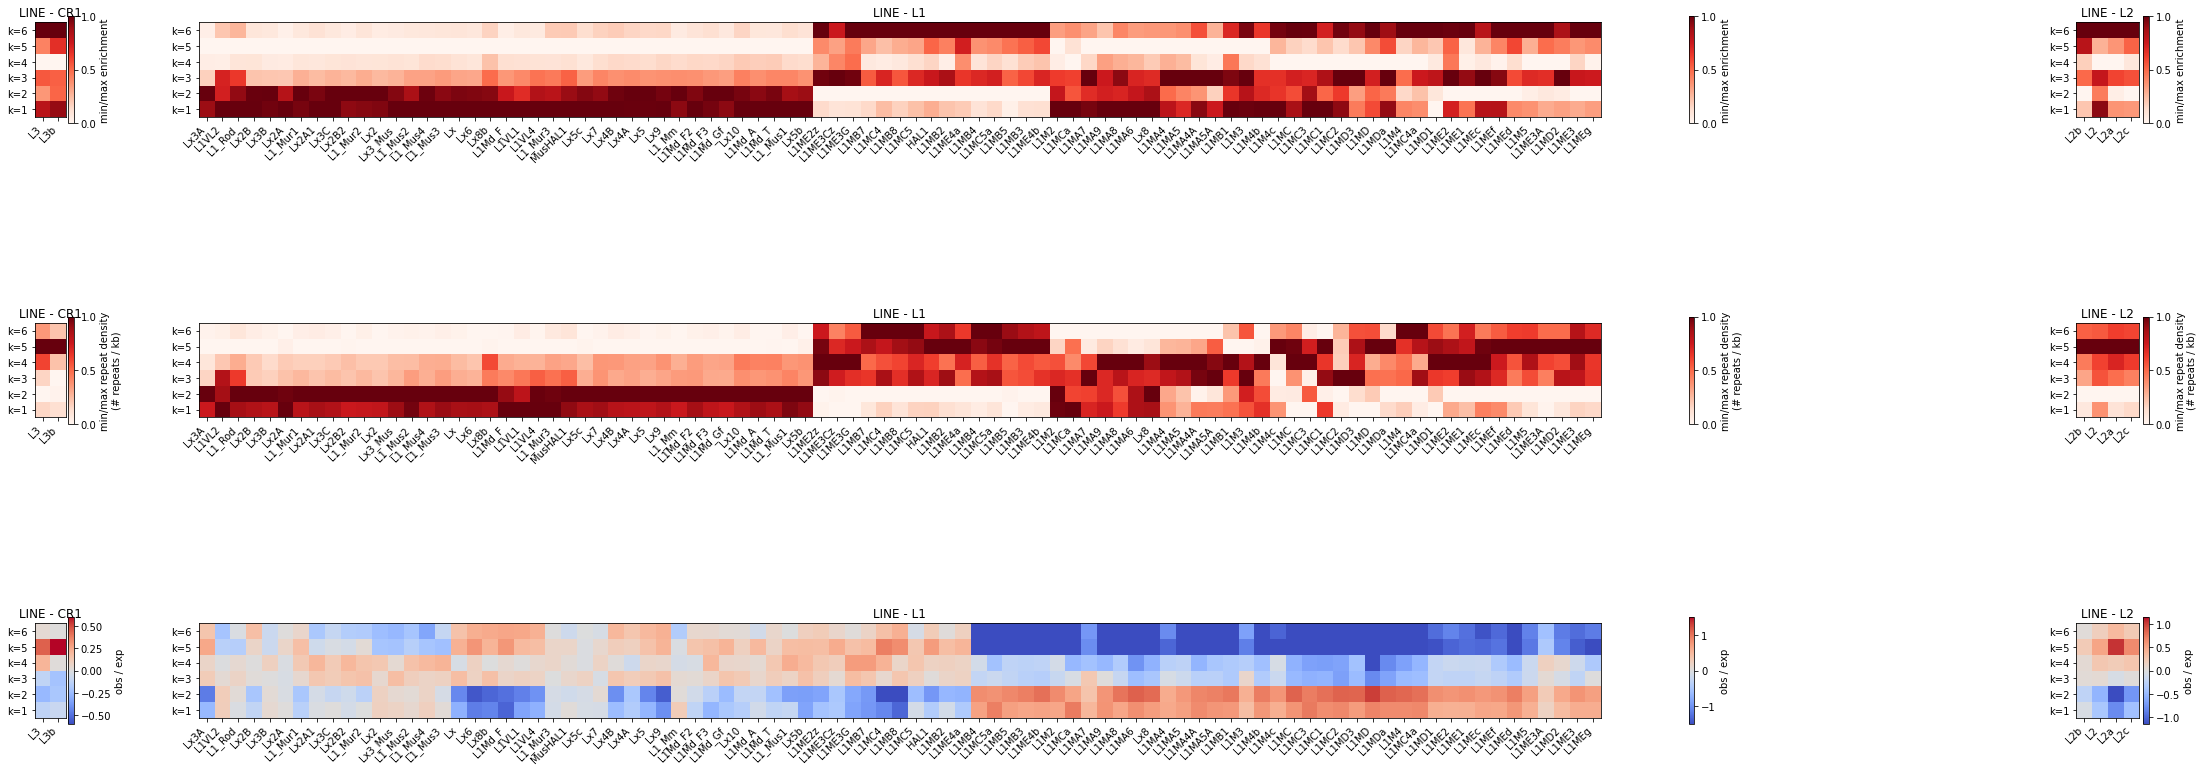

In [88]:
plot_repeatfam_summary('LINE', 1000)

## 7.4 Enrichment of LTR repeats

['ERV1' 'ERVK' 'ERVL' 'ERVL-MaLR']
[17, 86, 25, 58]


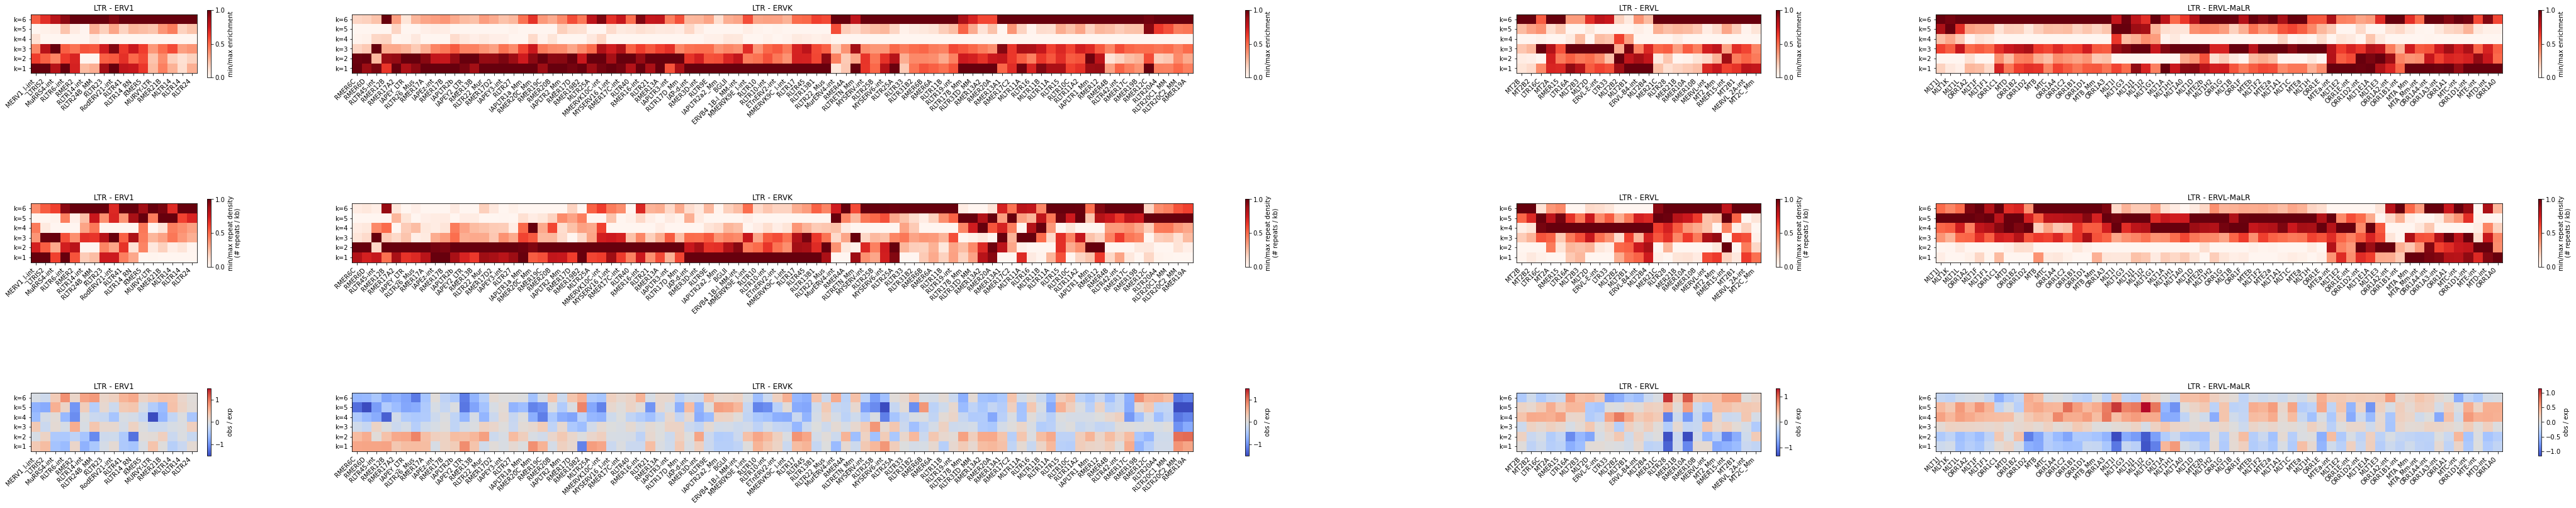

In [89]:
plot_repeatfam_summary('LTR', 1000)

## 7.5 Enrichment of DNA repeats

['TcMar-Tigger' 'hAT' 'hAT-Blackjack' 'hAT-Charlie']
[7, 1, 1, 17]


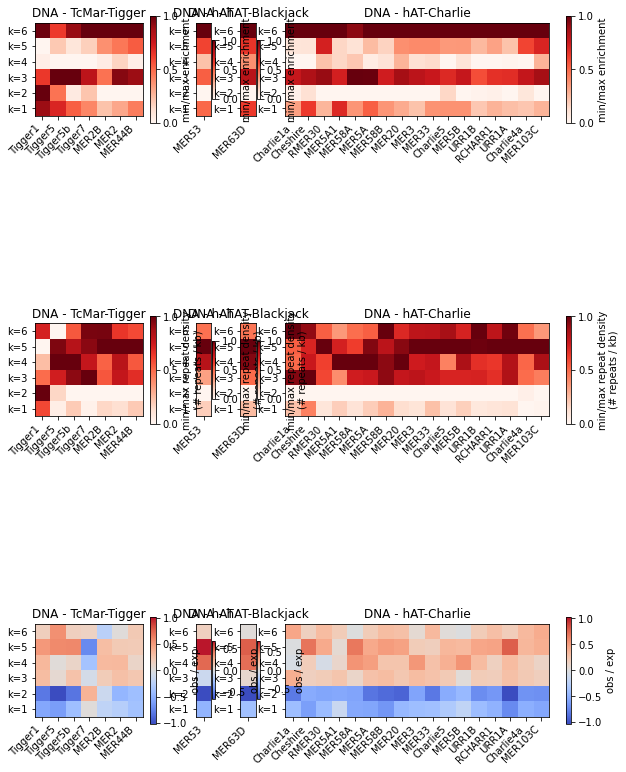

In [90]:
plot_repeatfam_summary('DNA', 1000)

## 7.6 Enrichment of SINE repeats

['Alu' 'B2' 'B4' 'Deu' 'ID' 'MIR' 'tRNA']
[15, 5, 4, 1, 4, 4, 1]


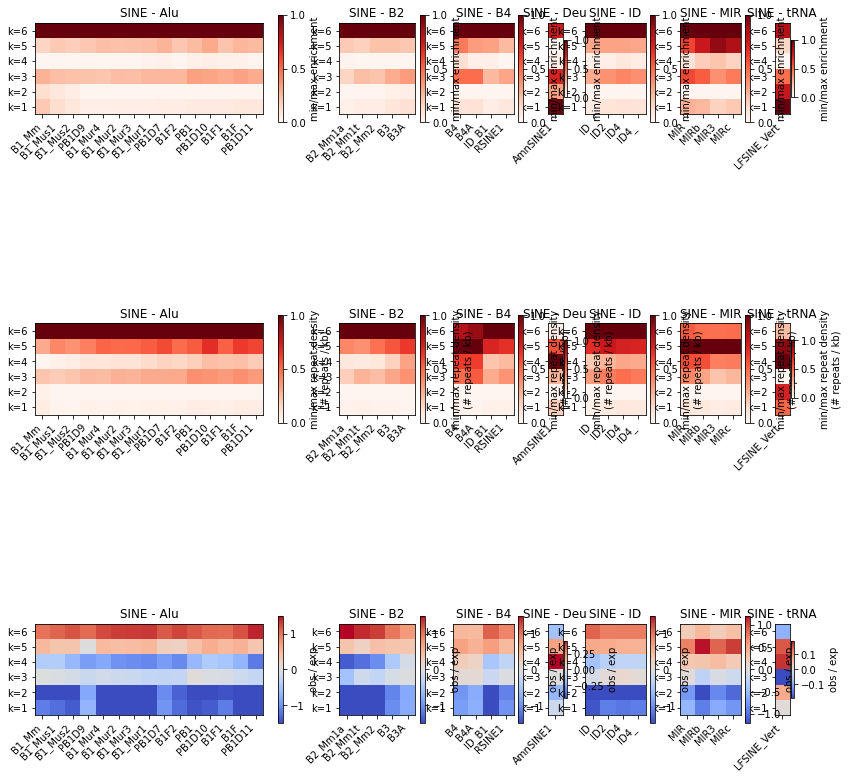

In [91]:
plot_repeatfam_summary('SINE', 1000)

## 7.7 Saving plots

LTR
['ERV1' 'ERVK' 'ERVL' 'ERVL-MaLR']
[17, 86, 25, 58]


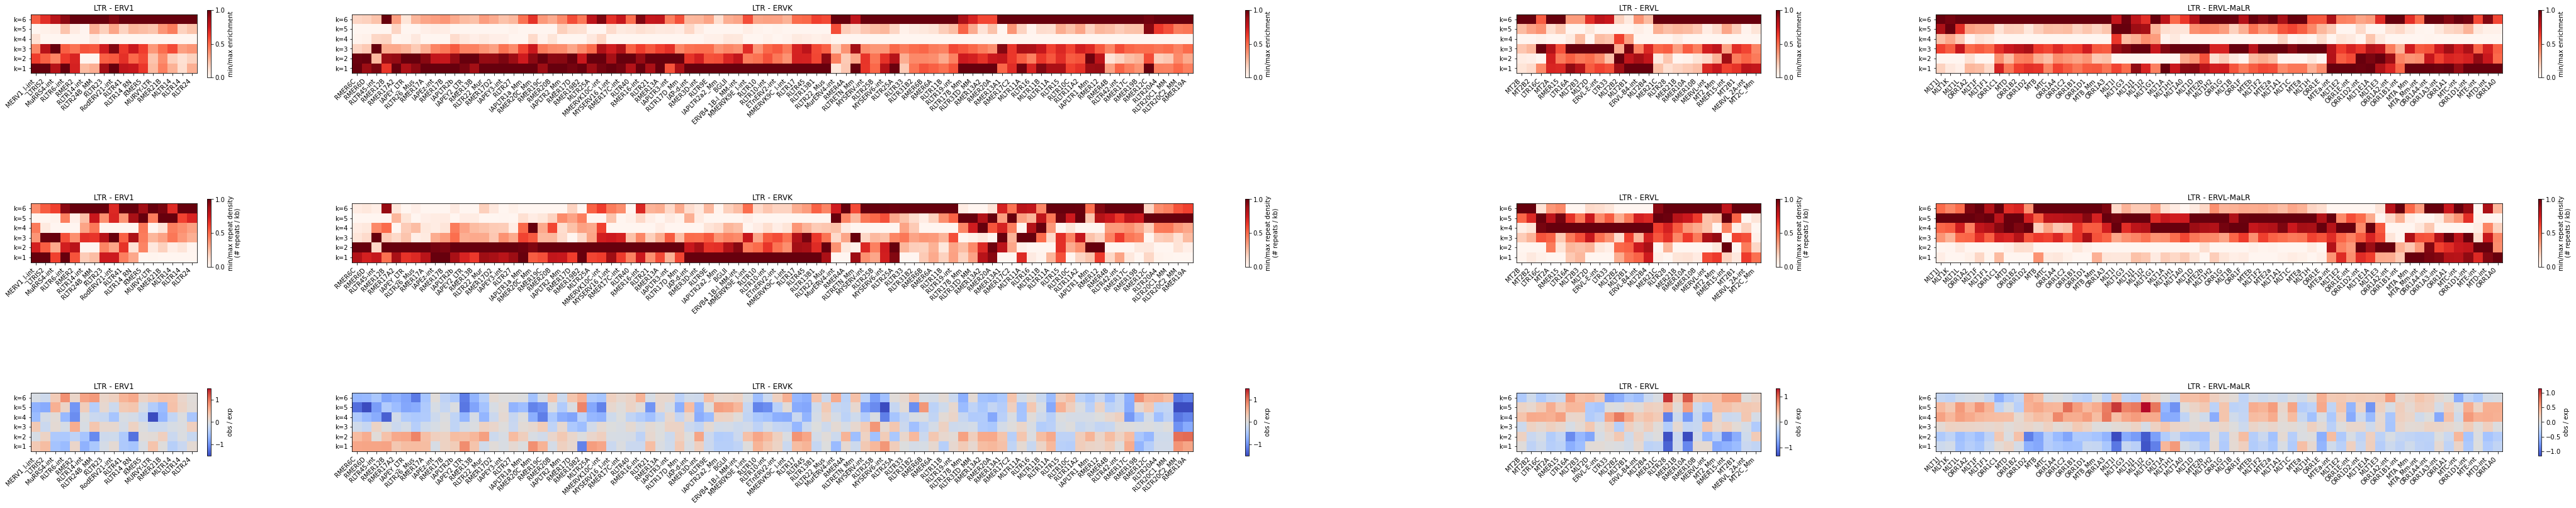

scRNA
['scRNA']
[2]


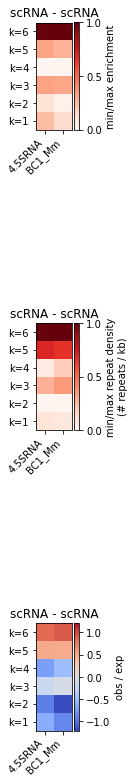

LINE
['CR1' 'L1' 'L2']
[2, 89, 4]


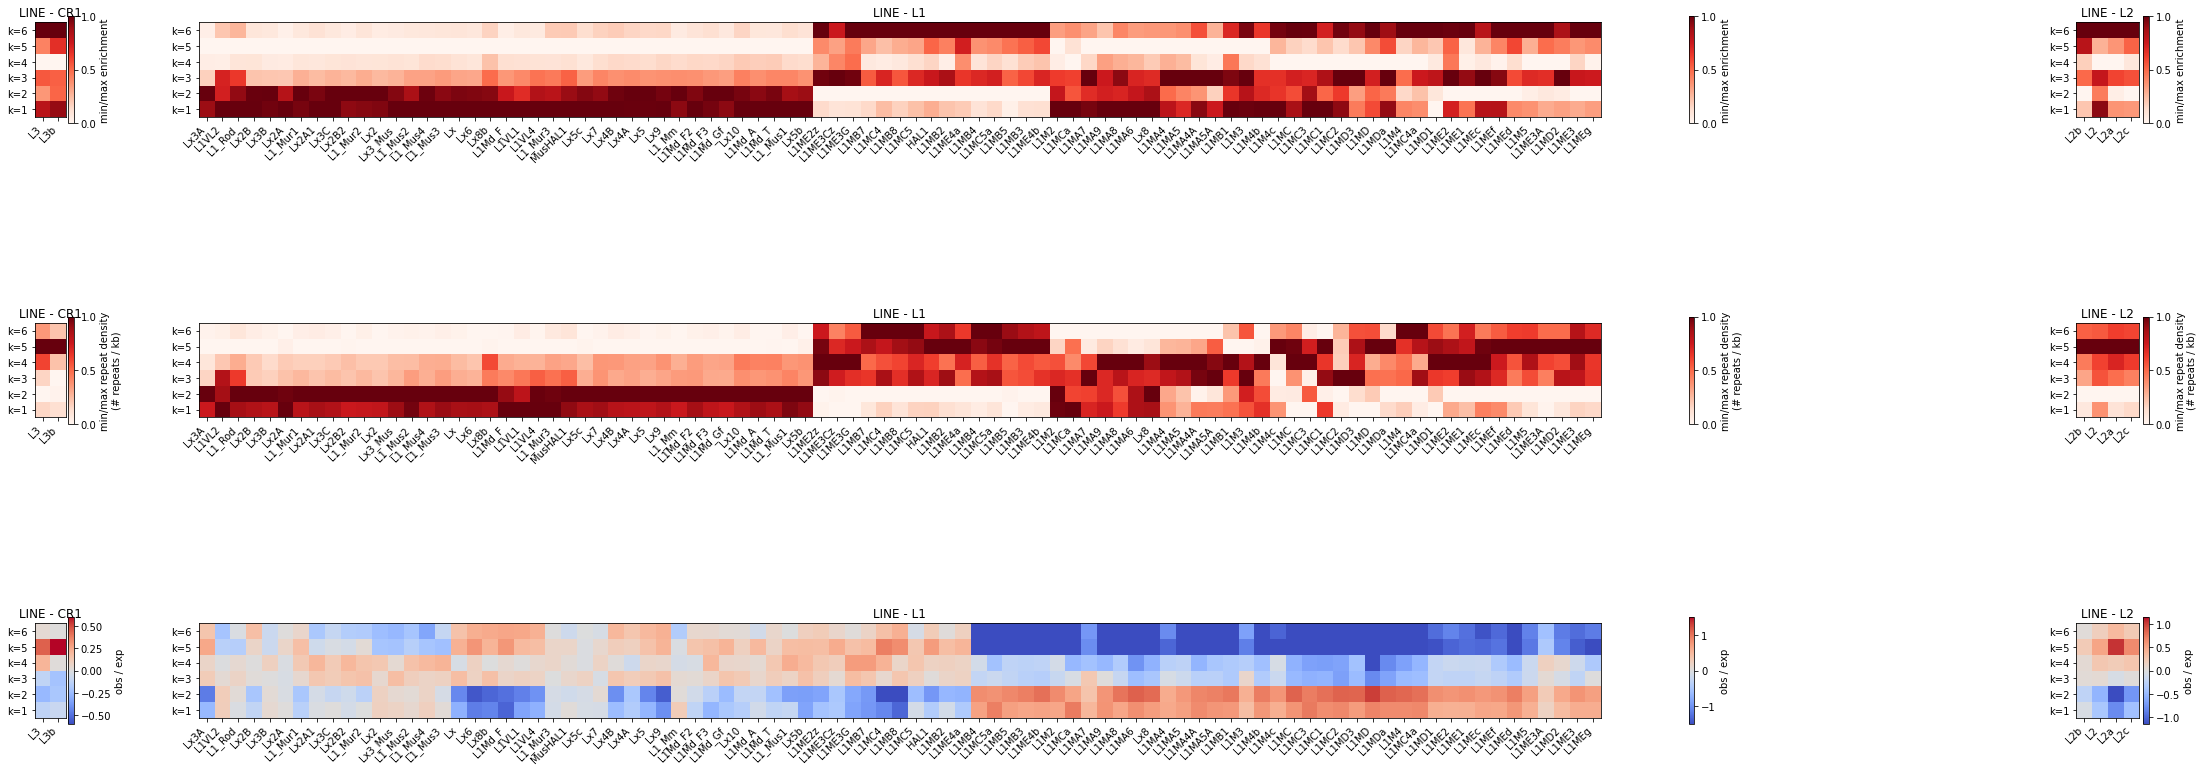

SINE
['Alu' 'B2' 'B4' 'Deu' 'ID' 'MIR' 'tRNA']
[15, 5, 4, 1, 4, 4, 1]


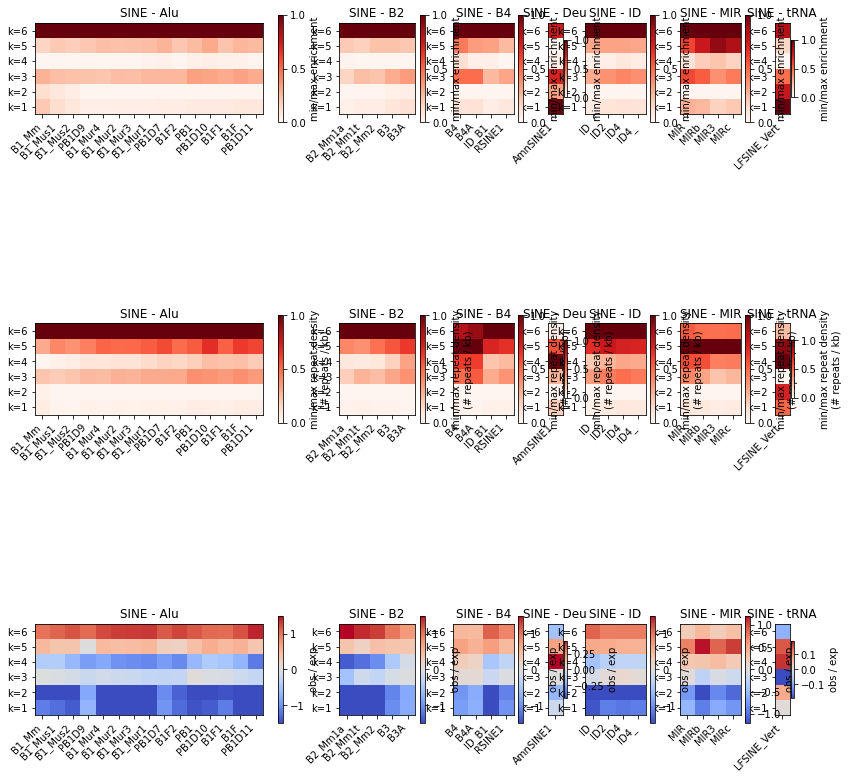

DNA
['TcMar-Tigger' 'hAT' 'hAT-Blackjack' 'hAT-Charlie']
[7, 1, 1, 17]


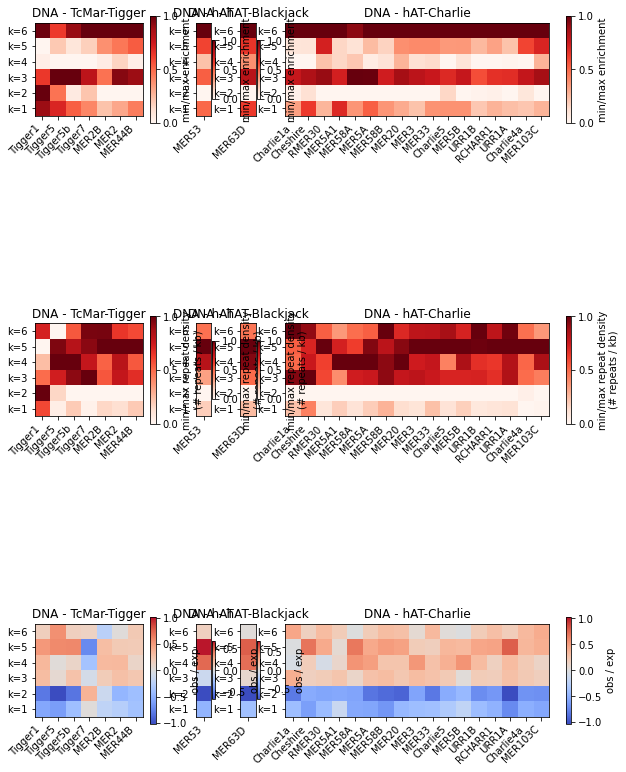

Satellite
['Satellite']
[4]


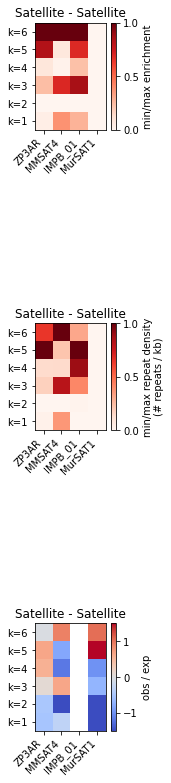

snRNA
['snRNA']
[1]


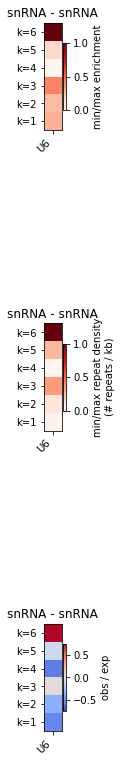

srpRNA
[]


<Figure size 432x288 with 0 Axes>

tRNA
['tRNA']
[1]


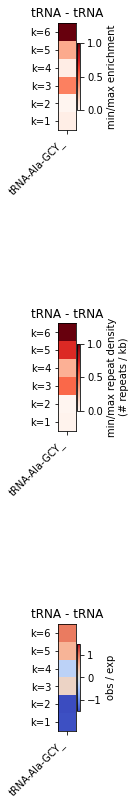

RNA
[]


<Figure size 432x288 with 0 Axes>

RC
[]


<Figure size 432x288 with 0 Axes>

rRNA
['rRNA']
[1]


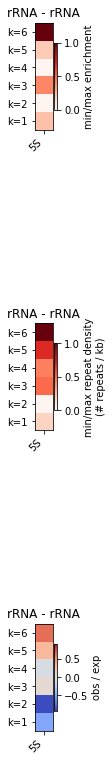

In [99]:
outfnfmt = FIGOUTDIR + 'REPEATS.clustered_heatmap.number_of_repeat_copies_in_clusters.repClass_%s.per_repFamily_and_repeat.min_%d_copies.pdf'
min_copies = 1000

for repclass in repeats.repClass.unique():
    print(repclass)
    
    plot_repeatfam_summary(repclass, 1000)
    outfn = outfnfmt % (repclass, min_copies)
    plt.savefig(outfn, bbox_inches='tight')
    plt.show()
    plt.close()

# 8. Save genes with annotation of the corresponding K-means cluster

In [80]:
tmp = bin_clusters[['chrom', 'bin_ind', 'Kcluster']].copy().rename(columns={'bin_ind': 'tss_bin'})
genes_per_cluster = genes.copy().merge(tmp, how='inner')
genes_per_cluster['gorkin_PcG'] = genes_per_cluster['gid'].isin(gorkin_genes.loc[gorkin_genes.gorkin_PcG, 'gid'].values)
tmp = park_clusters[['chrom', 'tss', 'tid', 'gid', 'Cluster']].copy().rename(columns={'Cluster': 'Park_cluster'})
tmp['Park_cluster'] = tmp['Park_cluster'].astype(str)
genes_per_cluster = genes_per_cluster.merge(tmp, how='left')
genes_per_cluster['Park_cluster'] = genes_per_cluster['Park_cluster'].fillna('no_cluster')

genes_per_cluster.to_csv('../data/FR231130.clustering_of_bins.genes_per_cluster.tsv.gz', sep='\t', header=True, index=False)

__Save genes for GO-term enrichment analysis__

In [81]:
# for k, df in genes_per_cluster[genes_per_cluster.gene_type=='protein_coding'].groupby('Kcluster'):
#     goi = pd.Series(df['gene_name'].unique())
#     goi.to_csv('../data/GO_term_enrichment/FR220617.K_cluster_%d.gene_names.txt' % k, index=False, header=False)
    
# goi = pd.Series(genes_per_cluster.loc[genes_per_cluster.gene_type=='protein_coding', 'gene_name'].unique())
# goi.to_csv('../data/GO_term_enrichment/FR220617.K_cluster_all.gene_names.txt', index=False, header=False)

# 9. Showing example tracks with cluster annotation

## 9.1 Function to plot genomic regions with cluster tracks

In [93]:
import itertools

In [94]:
from matplotlib import patches

In [95]:
def plot_genomic_region(to_plot, chrom, interval=[], plot_clusters=False, figw=5):
    
    # further select relevant data
    to_plot.loc[(to_plot.target == 'H3K9me3') & (to_plot.dataset_id == 'Encode_Hardison'), 'dataset_id'] = 'GSE97778'
    to_plot = to_plot[to_plot['target'] != 'input']
    to_plot = to_plot.sort_values(by=['technique', 'target', 'dataset_id', 'stage'])

    # determine figure layout
    nrow = len(to_plot) + (to_plot.is_heterozygous.sum() * 2)
    ncol = 1
    hr = [1]*nrow
    
    plot_clusters = False if len(interval) == 0 else plot_clusters
    if plot_clusters:
        nrow += 1
        hr = hr + [2]
    fig, axes = plt.subplots(nrow, ncol, figsize=(figw,sum(hr)*1.5), gridspec_kw={'height_ratios': hr})
    plt.subplots_adjust(hspace=.8)
    counter = 0

    if len(interval) == 0:
        interval_ind = np.arange(0, len(mapab[chrom]))
    else:
        s = int(interval[0]//BINSIZE)
        e = int(np.ceil(interval[1]/BINSIZE))
        interval_ind = np.arange(s, e+1)


    for _, row in to_plot.iterrows():

        parents = ['combined', 'maternal', 'paternal'] if row['is_heterozygous'] else ['combined']

        for parent in parents:

            # select data on chosen chrom
            if row['technique'] == 'DamID':
                C = contact_freq[parent][row['sample_id']][chrom]
                ylab = 'CF'
                title = 'DamID %s - %s - %s (%s)' % (row['target'], row['stage'], row['treatment'], row['genotype'])

            else:
                C = ext_data[parent][row['sample_id']][chrom]

                if row['control_id'] != 'none':
                    ctrl = ext_data[parent][row['control_id']][chrom]
                    C = np.log2( (C + 0.1) / (ctrl + 0.1) )
                    ylab = 'log2OE'
                else:
                    ylab = 'RPKM' if row['technique'] not in ['MethylC-Seq', 'TAB-seq', 'fCAB-seq'] else 'fraction CpG'

                title = '%s %s - %s - %s (%s)' % (row['technique'], row['target'], row['stage'], row['treatment'], row['sample_id'])

            X = np.arange(0, len(C)*BINSIZE, BINSIZE) / 1e6
            X = X[interval_ind]
            C = C[interval_ind]

            # select color
            if parent == 'combined':
                clr = color_dict['target'][row['target']] if row['target'] in color_dict['target'] else 'grey'
            else:
                clr = color_dict['allele'][parent]

            # plot
            ax = axes[counter]
            counter += 1

            ax.fill_between(X, 0, C, color=clr, lw=0)

            # format
            ax.set_title(title + (' - %s allele(s)' % parent))
            ax.set_ylabel(ylab)
            ax.set_xlim(X[0], X[-1])

            # set mat/pat axes equal
            if row['technique'] == 'DamID':
                ax.set_ylim(0,1)
            elif parent == 'paternal':
                ylim = np.array([axes[counter-2].get_ylim(), ax.get_ylim()])
                ylim = [ylim.min(axis=0)[0], ylim.max(axis=0)[1]]
                axes[counter-2].set_ylim(ylim)
                ax.set_ylim(ylim)


    if plot_clusters:
        ax = axes[-1]

        colorset = 'Set1'

        # plot patches
        ind = (bin_clusters.chrom==chrom)
        bin_ind = bin_clusters.loc[ind, 'bin_ind'].values
        k = bin_clusters.loc[ind, 'Kcluster'].values

        C = np.zeros(len(mapab[chrom]))
        C[:] = np.nan
        C[bin_ind] = k
        C = C[interval_ind]
        clus_ls = np.sort(np.unique(bin_clusters.Kcluster))
        nk = len(clus_ls)

        i_prev = 0
        for t in itertools.groupby(C):

            L = len(list(t[1]))

            if not np.isnan(t[0]):
                k = int(t[0])
                clr = sns.color_palette(colorset, n_colors=nk+1)[k-1]
                x = X[i_prev] - (0.5*BINSIZE/1e6)
                p = patches.Rectangle([x, k], width=L*BINSIZE/1e6, height=1, color=clr, lw=0)
                ax.add_patch(p)

            i_prev += L

        # plot one colormap
        C = np.atleast_2d(C)

        x1 = X[0] - (0.5*BINSIZE/1e6)
        x2 = X[-1] + (0.5*BINSIZE/1e6)
        p = ax.imshow(
            C, extent=[x1, x2, -2, -1], aspect='auto', interpolation='none', 
            cmap=colorset, vmin=1, vmax=10
        )
        print(clus_ls)
        print(np.arange(clus_ls[0], clus_ls[-1]+2)-.5)
        plt.colorbar(
            p, ax=ax, orientation='horizontal', shrink=.5, location='top', 
            ticks=clus_ls, drawedges=True, values=clus_ls, boundaries=np.arange(clus_ls[0], clus_ls[-1]+2)-.5)

        # format
        ax.set_yticks(clus_ls+.5)
        ax.set_yticklabels(clus_ls)
        ax.set_ylim(-2, nk+1)
        ax.set_xlim(X[0], X[-1])
        
    axes[-1].set_xlabel('chromosome %s [Mb]' % chrom)

## 9.2 Example region

[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]


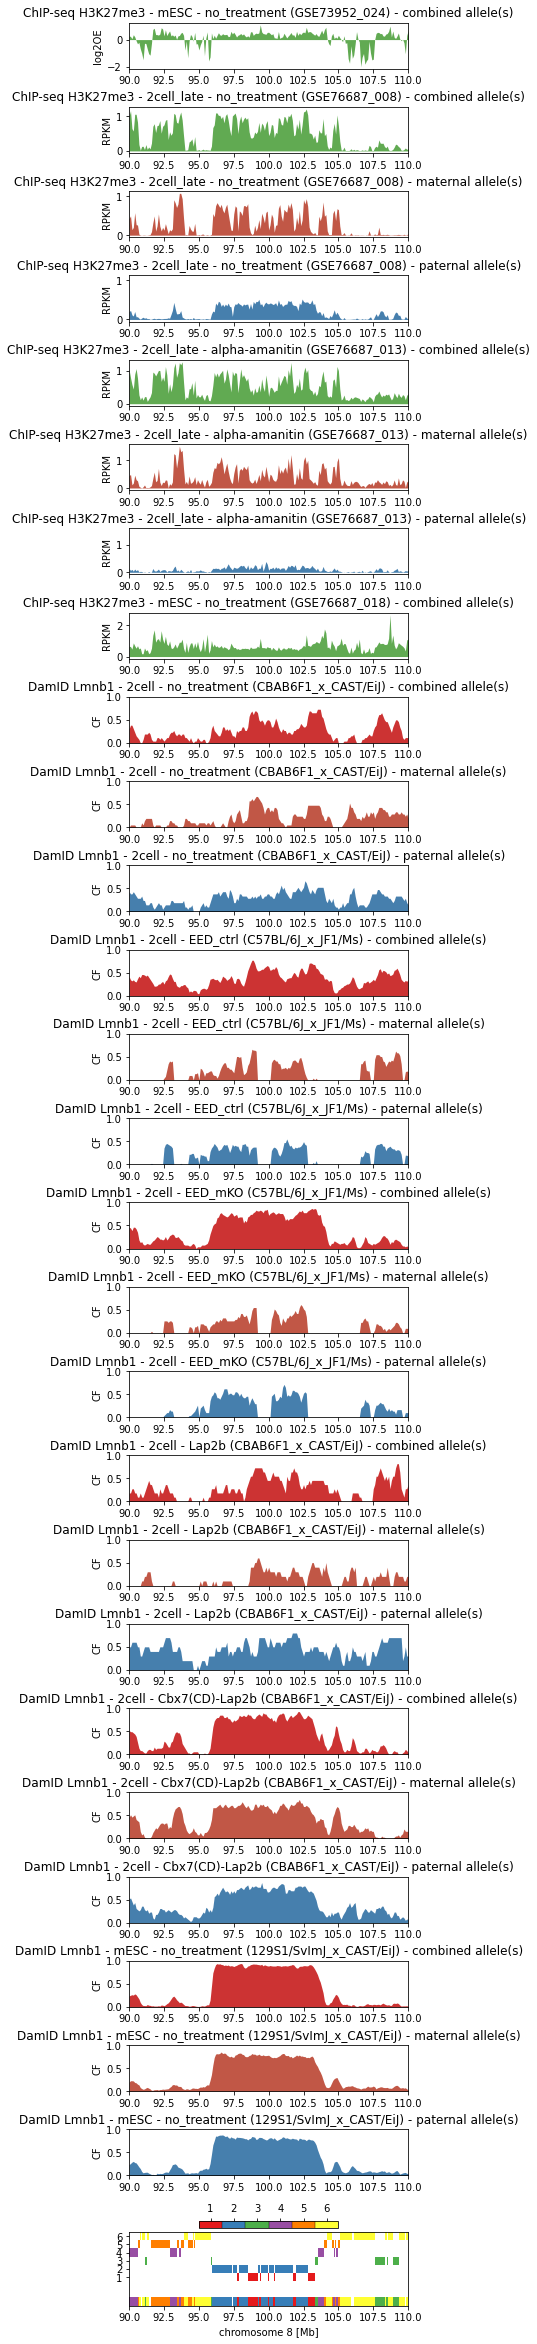

In [96]:
ind = comb_anno.stage.isin(['2cell', '2cell_late', 'mESC'])
to_plot = comb_anno[ind].copy()
to_plot = to_plot[(to_plot.is_heterozygous) | (to_plot.stage=='mESC')]
to_plot = to_plot[to_plot.target.isin(['Lmnb1', 'H3K27me3'])]
to_plot = to_plot[to_plot.dataset_id != 'Peters']

chrom = '8'
interval = [90e6,110e6] # 30-50, 50-70, 70-90
plot_clusters = True
figw = 5

plot_genomic_region(to_plot, chrom, interval, plot_clusters, figw)

## 9.3 Saving some regions of interest

In [97]:
regions_to_plot = [
    ['8', [35e6, 55e6], True, 5],
    ['8', [45e6, 65e6], True, 5],
    ['8', [90e6, 110e6], True, 5],
    ['12', [85e6, 105e6], True, 5],
    ['12', [52e6, 72e6], True, 5],
    ['17', [2e6, 22e6], True, 5],
    ['17', [30e6, 50e6], True, 5],
    ['17', [50e6, 70e6], True, 5],
    ['17', [70e6, 90e6], True, 5]
]

In [98]:
ind = comb_anno.stage.isin(['PN3_zygote', 'PN5_zygote', 'zygote', '2cell', '2cell_late', '8cell', 'mESC'])
to_plot = comb_anno[ind].copy()
to_plot = to_plot[(to_plot.is_heterozygous) | (to_plot.stage=='mESC')]

for (chrom, interval, plot_clusters, figw) in regions_to_plot:

    outfn = FIGOUTDIR + 'genomic_tracks.chr%s_%d_%d.pdf' % (chrom, int(interval[0]), int(interval[1]))
    plot_genomic_region(to_plot, chrom, interval, plot_clusters, figw)
    plt.savefig(outfn, bbox_inches='tight')
    plt.close()

[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
[1 2 3 4 5 6]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
